In [ ]:
#############################################################################
#   PROJET 7 Développez une preuve de concept                               #
#---------------------------------------------------------------------------#
#   NOTEBOOK                                                                #
#############################################################################

In [ ]:
# THEME : Neural Networks for Recommendations

In [ ]:
# MovieLens dataset : http://files.grouplens.org/datasets/movielens/ml-100k.zip
# Histoire et contexte : https://dl.acm.org/doi/10.1145/2827872
#
# Dataset largement utilisé dans l'éducation, la recherche et l'industrie. 
# Il est le produit de l'activité des membres du système de recommandation de films MovieLens, une plateforme de recherche
# active qui a hébergé de nombreuses expériences depuis son lancement en 1997.

# GroupLens Research currently operates a movie recommender based on collaborative filtering : http://www.movielens.org/

In [ ]:
#############################################################################
# PLAN CODE :                                                               #
#############################################################################
# 1. RECUPERATION DES DONNEES
# 2. EDA (EXPLORATORY DATA ANALYSIS)
#    2.1. STRUCTURE
#    2.2. VALEURS MANQUANTES
#    2.3. DOUBLONS
#    2.4. DATA CLEANING
#    2.5. ANALYSE UNIVARIEE
#    2.6. ANALYSE BIVARIEE
# 3. BASELINE : RANDOM RECOMMENDER SYSTEM
# 4. RECOMMENDING MOVIES WITH COLLABORATIVE FILTERING
#    4.1. MEMORY-BASED RECOMMENDATION SYSTEM (AVEC SURPRISE)
#    4.2. MODEL-BASED RECOMMENDATION SYSTEM
#         4.2.1. MATRIX FACTORISATION (AVEC SURPRISE)
#         4.2.2. AUTO-ENCODERS
#         4.2.3. NEURAL NETWORK
# 5. SYNTHESE

In [ ]:
#!pip install scikit-surprise

In [1]:
# built-in (librairie par défaut avec python)
import os

# data
import numpy as np
import pandas as pd
import seaborn as sns

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torch import optim

import statistics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Visualisation
import matplotlib.pyplot as plt
from PIL import Image

from surprise import KNNBasic, KNNWithMeans, SVD
from surprise import Reader
from surprise import Dataset
from surprise import NormalPredictor
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from collections import defaultdict

import time
from datetime import datetime # https://betterdatascience.com/python-timestamp/

In [2]:
C_DATASET_SOURCE  = './data/source/'
C_DATASET_CLEANED = './data/cleaned/'

# 1. RECUPERATION DES DONNEES

In [3]:
# Liste des fichiers fournis
os.listdir(C_DATASET_SOURCE)

['allbut.pl',
 'mku.sh',
 'README',
 'u.data',
 'u.genre',
 'u.info',
 'u.item',
 'u.occupation',
 'u.user',
 'u1.base',
 'u1.test',
 'u2.base',
 'u2.test',
 'u3.base',
 'u3.test',
 'u4.base',
 'u4.test',
 'u5.base',
 'u5.test',
 'ua.base',
 'ua.test',
 'ub.base',
 'ub.test']

In [ ]:
###################################################
#     Fichier README /SUMMARY & USAGE LICENSE     #
###################################################
# MovieLens data sets were collected by the GroupLens Research Project at the University of Minnesota.
#
# This data set consists of :
#     * 100 000 ratings (1-5) from 943 users on 1682 movies. 
#     * Each user has rated at least 20 movies. 
#     * Simple demographic info for the users (age, gender, occupation, zip)
#     
# The data was collected through the MovieLens web site (movielens.umn.edu) during the seven-month period from 
# September 19th, 1997 through April 22nd, 1998. 
# This data has been cleaned up - users who had less than 20 ratings or did not have complete demographic information were 
# removed from this data set.     

In [ ]:
############################################################
#   Fichier README / DETAILED DESCRIPTIONS OF DATA FILES   #
############################################################

In [ ]:
#--------------------------------------------------------------------------------------------#
# ml-data.tar.gz :                                                                           #
#--------------------------------------------------------------------------------------------#
# Compressed tar file. To rebuild the u data files do this:
#   gunzip ml-data.tar.gz
#   tar xvf ml-data.tar
#   mku.sh

In [4]:
#--------------------------------------------------------------------------------------------#
# u.data :                                                                                   #
#--------------------------------------------------------------------------------------------#
# The full u data set, 100.000 ratings by 943 users on 1682 items.
# Each user has rated at least 20 movies. 
# Users and items are numbered consecutively from 1. 
# The data is randomly ordered. 
# This is a tab separated list of :
#      user id | item id | rating | timestamp. 
# The time stamps are unix seconds since 1/1/1970 UTC 

# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

colnames_u_data = ['user_id', 'item_id', 'rating', 'timestamp']

df_u_data = pd.read_csv(C_DATASET_SOURCE + 'u.data', sep = '\t', header = None, names = colnames_u_data)
df_u_data.head(5)

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
#--------------------------------------------------------------------------------------------#
# u.genre :                                                                                  #
#--------------------------------------------------------------------------------------------#        
# A list of the genres.

colnames_u_genre = ['genre', 'genre_id']

df_u_genre = pd.read_csv(C_DATASET_SOURCE + 'u.genre', sep = '|', header = None, names = colnames_u_genre)
df_u_genre.head(5)

,genre,genre_id
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4


In [6]:
#--------------------------------------------------------------------------------------------#
# u.info  :                                                                                  #
#--------------------------------------------------------------------------------------------#
# The number of users, items, and ratings in the u data set : 100 000 ratings (1-5) from 943 users on 1682 movies.

colnames_u_info = ['nb', 'type']
                   
df_u_info = pd.read_csv(C_DATASET_SOURCE + 'u.info', sep = ' ', header = None, names = colnames_u_info)
df_u_info.head(5)

,nb,type
0,943,users
1,1682,items
2,100000,ratings


In [7]:
#--------------------------------------------------------------------------------------------#
# u.item :                                                                                   #
#--------------------------------------------------------------------------------------------#
# Information about the items (movies); this is a tab separated list of :
#      movie id | movie title | release date | video release date | IMDb URL | unknown | Action | Adventure | 
#      Animation | Children's | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical |
#      Mystery | Romance | Sci-Fi | Thriller | War | Western |
# The last 19 fields are the genres, a 1 indicates the movie is of that genre, a 0 indicates it is not; 
# movies can be in several genres at once.
# The movie ids are the ones used in the u.data data set.

colnames_u_item = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action',
                   'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                   'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'] 

df_u_item = pd.read_csv(C_DATASET_SOURCE + 'u.item', sep = '|', header = None, names = colnames_u_item,
                        encoding_errors = 'ignore') # pour éviter UnicodeDecodeError : 'utf-8' codec can't decode byte 
                                                    # 0xe9 in position 76620: invalid continuation byte
df_u_item.head(5)

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [8]:
#--------------------------------------------------------------------------------------------#
# u.occupation :                                                                             #
#--------------------------------------------------------------------------------------------#        
# A list of the occupations.

colnames_u_occupation = ['occupation']

df_u_occupation = pd.read_csv(C_DATASET_SOURCE + 'u.occupation', sep = '\t', header = None, names = colnames_u_occupation)
df_u_occupation.head(5)

,occupation
0,administrator
1,artist
2,doctor
3,educator
4,engineer


In [9]:
#--------------------------------------------------------------------------------------------#
# u.user :                                                                                   #
#--------------------------------------------------------------------------------------------#    
# Demographic information about the users; this is a tab separated list of :
#     user id | age | gender | occupation | zip code
# The user ids are the ones used in the u.data data set.

colnames_u_user = ['user_id', 'age', 'gender', 'occupation', 'zip_code']

df_u_user = pd.read_csv(C_DATASET_SOURCE + 'u.user', sep = '|', header = None, names = colnames_u_user)
df_u_user.head(5)

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [ ]:
#--------------------------------------------------------------------------------------------#
# u1.base, u1.test, u2.base, u2.test, u3.base, u3.test, u4.base, u4.test, u5.base, u5.test : #
#--------------------------------------------------------------------------------------------#
# The data sets u1.base and u1.test through u5.base and u5.test are 80% / 20% splits of the u data into training and 
# test data.
# Each of u1, ..., u5 have disjoint test sets; this if for 5 fold cross validation (where you repeat your experiment
# with each training and test set and average the results).
# These data sets can be generated from u.data by mku.sh => mêmes colonnes que u.data.

In [10]:
df_u1_base = pd.read_csv(C_DATASET_SOURCE + 'u1.base', sep = '\t', header = None, names = colnames_u_data)
df_u1_base.head(5)

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [11]:
df_u1_test = pd.read_csv(C_DATASET_SOURCE + 'u1.test', sep = '\t', header = None, names = colnames_u_data)
df_u1_test.head(5)

,user_id,item_id,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [12]:
df_u2_base = pd.read_csv(C_DATASET_SOURCE + 'u2.base', sep = '\t', header = None, names = colnames_u_data)
df_u2_base.head(5)

,user_id,item_id,rating,timestamp
0,1,3,4,878542960
1,1,4,3,876893119
2,1,5,3,889751712
3,1,6,5,887431973
4,1,7,4,875071561


In [13]:
df_u2_test = pd.read_csv(C_DATASET_SOURCE + 'u2.test', sep = '\t', header = None, names = colnames_u_data)
df_u2_test.head(5)

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,8,1,875072484
3,1,9,5,878543541
4,1,21,1,878542772


In [14]:
df_u3_base = pd.read_csv(C_DATASET_SOURCE + 'u3.base', sep = '\t', header = None, names = colnames_u_data)
df_u3_base.head(5)

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,6,5,887431973


In [15]:
df_u3_test = pd.read_csv(C_DATASET_SOURCE + 'u3.test', sep = '\t', header = None, names = colnames_u_data)
df_u3_test.head(5)

,user_id,item_id,rating,timestamp
0,1,5,3,889751712
1,1,11,2,875072262
2,1,16,5,878543541
3,1,25,4,875071805
4,1,35,1,878542420


In [16]:
df_u4_base = pd.read_csv(C_DATASET_SOURCE + 'u4.base', sep = '\t', header = None, names = colnames_u_data)
df_u4_base.head(5)

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,5,3,889751712
4,1,6,5,887431973


In [17]:
df_u4_test = pd.read_csv(C_DATASET_SOURCE + 'u4.test', sep = '\t', header = None, names = colnames_u_data)
df_u4_test.head(5)

,user_id,item_id,rating,timestamp
0,1,4,3,876893119
1,1,7,4,875071561
2,1,42,5,876892425
3,1,43,4,878542869
4,1,55,5,875072688


In [18]:
df_u5_base = pd.read_csv(C_DATASET_SOURCE + 'u5.base', sep = '\t', header = None, names = colnames_u_data)
df_u5_base.head(5)

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,4,3,876893119
3,1,5,3,889751712
4,1,6,5,887431973


In [19]:
df_u5_test = pd.read_csv(C_DATASET_SOURCE + 'u5.test', sep = '\t', header = None, names = colnames_u_data)
df_u5_test.head(5)

,user_id,item_id,rating,timestamp
0,1,3,4,878542960
1,1,13,5,875071805
2,1,15,5,875071608
3,1,18,4,887432020
4,1,19,5,875071515


In [ ]:
#--------------------------------------------------------------------------------------------#
# ua.base, ua.test, ub.base, ub.test :                                                       #
#--------------------------------------------------------------------------------------------#
# The data sets ua.base, ua.test, ub.base, and ub.test split the u data into a training set and a test set with exactly 
# 10 ratings per user in the test set. 
# The sets ua.test and ub.test are disjoint. These data sets can be generated from u.data by mku.sh => 
# mêmes colonnes que u.data.

In [20]:
df_ua_base = pd.read_csv(C_DATASET_SOURCE + 'ua.base', sep = '\t', header = None, names = colnames_u_data)
df_ua_base.head(5)

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [21]:
df_ua_test = pd.read_csv(C_DATASET_SOURCE + 'ua.test', sep = '\t', header = None, names = colnames_u_data)
df_ua_test.head(5)

,user_id,item_id,rating,timestamp
0,1,20,4,887431883
1,1,33,4,878542699
2,1,61,4,878542420
3,1,117,3,874965739
4,1,155,2,878542201


In [22]:
df_ub_base = pd.read_csv(C_DATASET_SOURCE + 'ub.base', sep = '\t', header = None, names = colnames_u_data)
df_ub_base.head(5)

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [23]:
df_ub_test = pd.read_csv(C_DATASET_SOURCE + 'ub.test', sep = '\t', header = None, names = colnames_u_data)
df_ub_test.head(5)

,user_id,item_id,rating,timestamp
0,1,17,3,875073198
1,1,47,4,875072125
2,1,64,5,875072404
3,1,90,4,878542300
4,1,92,3,876892425


In [ ]:
#--------------------------------------------------------------------------------------------#
# allbut.pl :                                                                                #
#--------------------------------------------------------------------------------------------#
# The script that generates training and test sets where all but n of a users ratings are in the training data.

In [ ]:
#--------------------------------------------------------------------------------------------#
# mku.sh :                                                                                   #
#--------------------------------------------------------------------------------------------#
# A shell script to generate all the u data sets from u.data.

# 2. EDA (EXPLORATORY DATA ANALYSIS)

# 2.1. STRUCTURE

In [24]:
def structure_df(df_in, df_name_in):

    size = len(df_name_in)
    
    # colonnes
    print('@' * 50, df_name_in, '/ columns', '@' * (63 - size))
    print(df_in.columns, '\n\n')
    
    # nombre de lignes et nombre de colonnes
    print('@' * 50, df_name_in, '/ shape', '@' * (65 - size))
    print(df_in.shape, '\n\n')

    print('@' * 50, df_name_in, '/ info', '@' * (66 - size))
    print(df_in.info(), '\n\n')
    
    # type des colonnes
    print('@' * 50, df_name_in, '/ dtypes', '@' * (64 - size))
    print(df_in.dtypes, '\n\n')

    # nombre de colonnes de chaque dtypes (sert si 100 colonnes par exemple)
    print('@' * 50, df_name_in, '/ value_counts', '@' * (58 - size))
    print(df_in.dtypes.value_counts(), '\n\n')
    
    # nombre de valeurs uniques par colonne
    print('@' * 50, df_name_in, '/ nunique', '@' * (63 - size))
    print(df_in.nunique(), '\n\n')
    
    # unique values (<=> valeur unique dans summary statistics)
    print('@' * 50, df_name_in, '/ unique par colonne', '@' * (52 - size))
    for col in df_in.columns:
        # affichage uniquement si < 30 éléments        
        if (len(df_in[col].unique()) <= 30):
            print(col, ':', df_in[col].unique(), '\n')

In [25]:
###########################################
# structure u.genre                       #
###########################################
structure_df(df_in      = df_u_genre,
             df_name_in = 'u.genre')

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u.genre / columns @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Index(['genre', 'genre_id'], dtype='object') 


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u.genre / shape @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
(19, 2) 


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u.genre / info @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   genre     19 non-null     object
 1   genre_id  19 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 432.0+ bytes
None 


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u.genre / dtypes @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
genre       object
genre_id     int64
dtype: object 


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u.genre / valu

In [26]:
# définition de listes
movie_liste_genre    = df_u_genre['genre'].unique().tolist()
movie_liste_genre_id = df_u_genre['genre_id'].unique().tolist() 

print('movie_liste_genre =', movie_liste_genre, '\n')
print('movie_liste_genre_id =', movie_liste_genre_id)

movie_liste_genre = ['unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'] 

movie_liste_genre_id = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


In [27]:
###########################################
# structure u.info                        #
###########################################
structure_df(df_in      = df_u_info,
             df_name_in = 'u.info')

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u.info / columns @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Index(['nb', 'type'], dtype='object') 


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u.info / shape @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
(3, 2) 


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u.info / info @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   nb      3 non-null      int64 
 1   type    3 non-null      object
dtypes: int64(1), object(1)
memory usage: 176.0+ bytes
None 


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u.info / dtypes @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
nb       int64
type    object
dtype: object 


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u.info / value_counts @@@@@@@@@@@@@@@@@@

In [28]:
###########################################
# structure u.item                        #
###########################################
structure_df(df_in      = df_u_item,
             df_name_in = 'u.item')

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u.item / columns @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Index(['movie_id', 'movie_title', 'release_date', 'video_release_date',
       'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children's',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'],
      dtype='object') 


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u.item / shape @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
(1682, 24) 


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u.item / info @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            1682 non-null   int64  
 1   

In [29]:
###########################################
# structure u.occupation                  #
###########################################
structure_df(df_in      = df_u_occupation,
             df_name_in = 'u.occupation')

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u.occupation / columns @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Index(['occupation'], dtype='object') 


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u.occupation / shape @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
(21, 1) 


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u.occupation / info @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   occupation  21 non-null     object
dtypes: object(1)
memory usage: 296.0+ bytes
None 


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u.occupation / dtypes @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
occupation    object
dtype: object 


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u.occupation / value_counts @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
objec

In [146]:
# Remarque : on crée une liste pour la colonne occupation avec le df df_u_user.

In [30]:
###########################################
# structure u.user                        #
###########################################
structure_df(df_in      = df_u_user,
             df_name_in = 'u.user')

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u.user / columns @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Index(['user_id', 'age', 'gender', 'occupation', 'zip_code'], dtype='object') 


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u.user / shape @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
(943, 5) 


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u.user / info @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     943 non-null    int64 
 1   age         943 non-null    int64 
 2   gender      943 non-null    object
 3   occupation  943 non-null    object
 4   zip_code    943 non-null    object
dtypes: int64(2), object(3)
memory usage: 37.0+ KB
None 


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u.user / dtypes @@@@@@@@@@@@@@@@@@@

In [31]:
# définition de listes
user_liste_gender     = df_u_user['gender'].unique().tolist()
user_liste_occupation = df_u_user['occupation'].unique().tolist()

print('user_liste_gender =', user_liste_gender, '\n')
print('user_liste_occupation =', user_liste_occupation)

user_liste_gender = ['M', 'F'] 

user_liste_occupation = ['technician', 'other', 'writer', 'executive', 'administrator', 'student', 'lawyer', 'educator', 'scientist', 'entertainment', 'programmer', 'librarian', 'homemaker', 'artist', 'engineer', 'marketing', 'none', 'healthcare', 'retired', 'salesman', 'doctor']


In [32]:
###########################################
# structure u.data                        #
###########################################
structure_df(df_in      = df_u_data,
             df_name_in = 'u.data')

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u.data / columns @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Index(['user_id', 'item_id', 'rating', 'timestamp'], dtype='object') 


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u.data / shape @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
(100000, 4) 


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u.data / info @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB
None 


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u.data / dtypes @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
user_id      int64
i

In [33]:
print(len(df_u_data['user_id'].unique()), '\tuser_id')
print(len(df_u_data['item_id'].unique()), '\titem_id')
print(len(df_u_data.index), '\trating')

943 	user_id
1682 	item_id
100000 	rating


In [34]:
###########################################
# structure u1.base                       #
###########################################
structure_df(df_in      = df_u1_base,
             df_name_in = 'u1.base')

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u1.base / columns @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Index(['user_id', 'item_id', 'rating', 'timestamp'], dtype='object') 


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u1.base / shape @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
(80000, 4) 


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u1.base / info @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id    80000 non-null  int64
 1   item_id    80000 non-null  int64
 2   rating     80000 non-null  int64
 3   timestamp  80000 non-null  int64
dtypes: int64(4)
memory usage: 2.4 MB
None 


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u1.base / dtypes @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
user_id      int64
item_id  

In [35]:
###########################################
# structure u1.test                       #
###########################################
structure_df(df_in      = df_u1_test,
             df_name_in = 'u1.test')

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u1.test / columns @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Index(['user_id', 'item_id', 'rating', 'timestamp'], dtype='object') 


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u1.test / shape @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
(20000, 4) 


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u1.test / info @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id    20000 non-null  int64
 1   item_id    20000 non-null  int64
 2   rating     20000 non-null  int64
 3   timestamp  20000 non-null  int64
dtypes: int64(4)
memory usage: 625.1 KB
None 


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ u1.test / dtypes @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
user_id      int64
item_id

In [36]:
###########################################
# structure ua.base                       #
###########################################
structure_df(df_in      = df_ua_base,
             df_name_in = 'ua.base')

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ ua.base / columns @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Index(['user_id', 'item_id', 'rating', 'timestamp'], dtype='object') 


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ ua.base / shape @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
(90570, 4) 


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ ua.base / info @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90570 entries, 0 to 90569
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id    90570 non-null  int64
 1   item_id    90570 non-null  int64
 2   rating     90570 non-null  int64
 3   timestamp  90570 non-null  int64
dtypes: int64(4)
memory usage: 2.8 MB
None 


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ ua.base / dtypes @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
user_id      int64
item_id  

In [37]:
###########################################
# structure ua.test                       #
###########################################
structure_df(df_in      = df_ua_test,
             df_name_in = 'ua.test')

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ ua.test / columns @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Index(['user_id', 'item_id', 'rating', 'timestamp'], dtype='object') 


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ ua.test / shape @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
(9430, 4) 


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ ua.test / info @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9430 entries, 0 to 9429
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id    9430 non-null   int64
 1   item_id    9430 non-null   int64
 2   rating     9430 non-null   int64
 3   timestamp  9430 non-null   int64
dtypes: int64(4)
memory usage: 294.8 KB
None 


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ ua.test / dtypes @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
user_id      int64
item_id   

# 2.2. VALEURS MANQUANTES

In [38]:
for df, df_name in [[df_u_genre, 'u.genre'], [df_u_info, 'u.info'], [df_u_item, 'u.item'], 
                    [df_u_occupation, 'u.occupation'], [df_u_user, 'u.user'], [df_u_data, 'u.data'],
                    [df_u1_base, 'u1.base'], [df_u1_test, 'u1.test'],
                    [df_ua_base, 'ua.base'], [df_ua_test, 'ua.test']]:
    
    print(df_name, ':')
    
    # Nombre de valeurs manquantes    
    nb_na = df.isna().sum()
    print(nb_na[nb_na > 0])
    
    # Nombre de valeurs manquantes en pourcentage
    nb_na_p100 = df.isna().mean()
    print(nb_na_p100[nb_na_p100 > 0], '\n')
    
# Nous confirmons que ce dataset ne contient aucune valeur manquante, excepté u.item.

u.genre :
Series([], dtype: int64)
Series([], dtype: float64) 

u.info :
Series([], dtype: int64)
Series([], dtype: float64) 

u.item :
release_date             1
video_release_date    1682
IMDb_URL                 3
dtype: int64
release_date          0.000595
video_release_date    1.000000
IMDb_URL              0.001784
dtype: float64 

u.occupation :
Series([], dtype: int64)
Series([], dtype: float64) 

u.user :
Series([], dtype: int64)
Series([], dtype: float64) 

u.data :
Series([], dtype: int64)
Series([], dtype: float64) 

u1.base :
Series([], dtype: int64)
Series([], dtype: float64) 

u1.test :
Series([], dtype: int64)
Series([], dtype: float64) 

ua.base :
Series([], dtype: int64)
Series([], dtype: float64) 

ua.test :
Series([], dtype: int64)
Series([], dtype: float64) 



In [39]:
def valeurs_manquantes(df_in):

    # représentation graphique des valeurs manquantes
    fig, ax = plt.subplots(1, 1, figsize = (15, 5))
    sns.heatmap(df_in.isna())

    # blanc <=> il y a une / des valeurs.
    # noir <=> il n'y a pas de valeur.

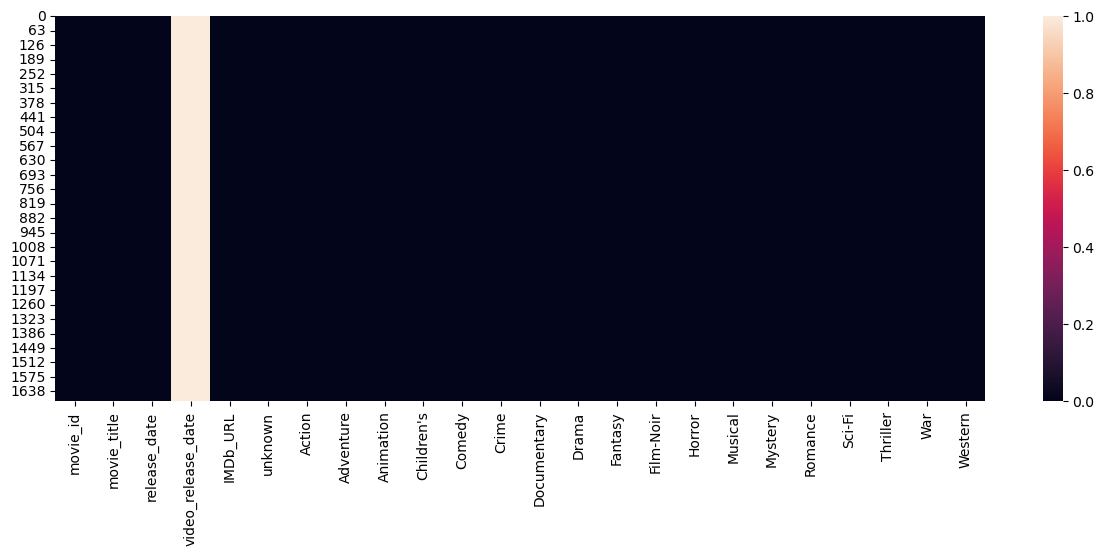

In [40]:
# Zoom valeurs manquantes u.item
valeurs_manquantes(df_in = df_u_item)

In [41]:
# Suppression colonne video_release_date car contient 100% de valeurs manquantes.
df_u_item.drop(['video_release_date'], axis = 1, inplace = True)

In [42]:
# Suppression lignes contenant valeurs NaN.
# https://www.delftstack.com/fr/api/python-pandas/pandas-dataframe-dataframe.dropna-function/
print('df_u_item shape avant suppression :', df_u_item.shape)
df_u_item = df_u_item.dropna()
print('df_u_item shape après suppression :', df_u_item.shape)

df_u_item shape avant suppression : (1682, 23)
df_u_item shape après suppression : (1679, 23)


In [43]:
# Vérification qu'il n'y a plus de valeurs manquantes pour df_u_item
nb_na = df_u_item.isna().sum()
print(nb_na[nb_na > 0])

Series([], dtype: int64)


# 2.3. DOUBLONS

In [44]:
######################################################
# Doublons de lignes total.                          #
######################################################
for df, df_name in [[df_u_genre, 'u.genre'], [df_u_info, 'u.info'], [df_u_item, 'u.item'], 
                    [df_u_occupation, 'u.occupation'], [df_u_user, 'u.user'], [df_u_data, 'u.data'],
                    [df_u1_base, 'u1.base'], [df_u1_test, 'u1.test'],
                    [df_ua_base, 'ua.base'], [df_ua_test, 'ua.test']]:
    
    doublons_lignes = df.duplicated().sum()
    print(doublons_lignes, 'lignes en doublon :', df_name)

0 lignes en doublon : u.genre
0 lignes en doublon : u.info
0 lignes en doublon : u.item
0 lignes en doublon : u.occupation
0 lignes en doublon : u.user
0 lignes en doublon : u.data
0 lignes en doublon : u1.base
0 lignes en doublon : u1.test
0 lignes en doublon : ua.base
0 lignes en doublon : ua.test


In [45]:
############################################################################
# Doublon de lignes sur des colonnes spécifiques : movie_id et movie_title #
############################################################################
# https://statorials.org/pandas-trouver-des-doublons/
duplicate_rows = df_u_item[df_u_item.duplicated(['movie_id', 'movie_title'])]
duplicate_rows

,movie_id,movie_title,release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western


In [46]:
######################################################
# Doublon de lignes sur une colonne : movie_title    #
######################################################
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.duplicated.html
# keep = False : Mark all duplicates as True.
df_duplicate_title_all_movies = df_u_item[df_u_item['movie_title'].duplicated(keep = False)]
df_duplicate_title_all_movies[['movie_id', 'movie_title', 'release_date']]

,movie_id,movie_title,release_date
245,246,Chasing Amy (1997),01-Jan-1997
265,266,Kull the Conqueror (1997),29-Aug-1997
267,268,Chasing Amy (1997),01-Jan-1997
296,297,Ulee's Gold (1997),01-Jan-1997
302,303,Ulee's Gold (1997),01-Jan-1997
303,304,Fly Away Home (1996),13-Sep-1996
304,305,"Ice Storm, The (1997)",01-Jan-1997
308,309,Deceiver (1997),01-Jan-1997
328,329,Desperate Measures (1998),30-Jan-1998
347,348,Desperate Measures (1998),30-Jan-1998


In [47]:
# liste des movie_title étant dupliqués (valuers uniques)
liste_duplicate_title = df_duplicate_title_all_movies['movie_title'].unique().tolist()

print(len(liste_duplicate_title), 'éléments liste_duplicate_title =', liste_duplicate_title)

18 éléments liste_duplicate_title = ['Chasing Amy (1997)', 'Kull the Conqueror (1997)', "Ulee's Gold (1997)", 'Fly Away Home (1996)', 'Ice Storm, The (1997)', 'Deceiver (1997)', 'Desperate Measures (1998)', 'Body Snatchers (1993)', 'Substance of Fire, The (1996)', 'Money Talks (1997)', 'That Darn Cat! (1997)', 'Hugo Pool (1997)', 'Chairman of the Board (1998)', 'Designated Mourner, The (1997)', 'Hurricane Streets (1998)', 'Sliding Doors (1998)', 'Nightwatch (1997)', 'Butcher Boy, The (1998)']


In [48]:
for title in liste_duplicate_title:
    print('@' * 20, 'title =', title, '@' * 20)
    
    # dataframe avec un titre dupliqué
    df_u_item_one_title = df_u_item[df_u_item['movie_title'] == title]
    print(df_u_item_one_title[['movie_id', 'movie_title', 'release_date']], '\n')
    
    # Liste des différents movie_id correspondant au même film (<=> lignes dupliquées)
    liste_movie_index = df_u_item_one_title.index.tolist()
    liste_movie_id    = df_u_item_one_title['movie_id'].tolist()
    print('liste_movie_index df_u_item =', liste_movie_index)    
    print('liste_movie_id    df_u_item =', liste_movie_id)

    # On ne conserve que le 1er élément de la liste
    new_movie_index = liste_movie_index[0]
    new_movie_id    = liste_movie_id[0]
    print('=> new_movie_index\t=', new_movie_index)    
    print('=> new_movie_id\t\t=', new_movie_id, '\n')

    
    
    # Maj dataframes u.data, ui.base, ui.test : on remplace les numéros du même film par le movie_id minimum
    for df_name in ['df_u_data', 'df_u1_base', 'df_u1_test', 'df_u2_base', 'df_u2_test', 'df_u3_base', 'df_u3_test',
                    'df_u4_base', 'df_u4_test', 'df_u5_base', 'df_u5_test']:        
        
        # Mise à jour dans le dataset
        if (df_name == 'df_u_data'): 
            # Sous-dataframe avec les films ayant le titre sélectionné
            df_u_data_one_title = df_u_data[df_u_data['item_id'].isin(liste_movie_id)]
            df_u_data.loc[df_u_data_one_title.index, 'item_id'] = new_movie_id
            
        elif (df_name == 'df_u1_base'):
            df_u_data_one_title = df_u1_base[df_u1_base['item_id'].isin(liste_movie_id)]
            df_u1_base.loc[df_u_data_one_title.index, 'item_id'] = new_movie_id
            
        elif (df_name == 'df_u1_test'):
            df_u_data_one_title = df_u1_test[df_u1_test['item_id'].isin(liste_movie_id)]
            df_u1_test.loc[df_u_data_one_title.index, 'item_id'] = new_movie_id
            
        elif (df_name == 'df_u2_base'):
            df_u_data_one_title = df_u2_base[df_u2_base['item_id'].isin(liste_movie_id)]            
            df_u2_base.loc[df_u_data_one_title.index, 'item_id'] = new_movie_id
            
        elif (df_name == 'df_u2_test'):
            df_u_data_one_title = df_u2_test[df_u2_test['item_id'].isin(liste_movie_id)]            
            df_u2_test.loc[df_u_data_one_title.index, 'item_id'] = new_movie_id      
            
        elif (df_name == 'df_u3_base'):
            df_u_data_one_title = df_u3_base[df_u3_base['item_id'].isin(liste_movie_id)]            
            df_u3_base.loc[df_u_data_one_title.index, 'item_id'] = new_movie_id     
            
        elif (df_name == 'df_u3_test'):
            df_u_data_one_title = df_u3_test[df_u3_test['item_id'].isin(liste_movie_id)]            
            df_u3_test.loc[df_u_data_one_title.index, 'item_id'] = new_movie_id        
            
        elif (df_name == 'df_u4_base'):
            df_u_data_one_title = df_u4_base[df_u4_base['item_id'].isin(liste_movie_id)]            
            df_u4_base.loc[df_u_data_one_title.index, 'item_id'] = new_movie_id   
            
        elif (df_name == 'df_u4_test'):
            df_u_data_one_title = df_u4_test[df_u4_test['item_id'].isin(liste_movie_id)]            
            df_u4_test.loc[df_u_data_one_title.index, 'item_id'] = new_movie_id     
            
        elif (df_name == 'df_u5_base'):
            df_u_data_one_title = df_u5_base[df_u5_base['item_id'].isin(liste_movie_id)]            
            df_u5_base.loc[df_u_data_one_title.index, 'item_id'] = new_movie_id
            
        elif (df_name == 'df_u5_test'):
            df_u_data_one_title = df_u5_test[df_u5_test['item_id'].isin(liste_movie_id)]            
            df_u5_test.loc[df_u_data_one_title.index, 'item_id'] = new_movie_id
            
        print(df_name, '\t:', len(df_u_data_one_title.index), '\titem_id corrigés')

    # Suppression des doublons dans df_u_item
    liste_movie_index.remove(new_movie_index) # On enlève le film qu'on garde dans la liste des films à supprimer.
    df_u_item.drop(liste_movie_index, axis = 0, inplace = True)       
    print('df_u_item\t:', len(liste_movie_index), '\tligne(s) index', liste_movie_index, 'supprimée(s)\n\n')    

@@@@@@@@@@@@@@@@@@@@ title = Chasing Amy (1997) @@@@@@@@@@@@@@@@@@@@
     movie_id         movie_title release_date
245       246  Chasing Amy (1997)  01-Jan-1997
267       268  Chasing Amy (1997)  01-Jan-1997 

liste_movie_index df_u_item = [245, 267]
liste_movie_id    df_u_item = [246, 268]
=> new_movie_index	= 245
=> new_movie_id		= 246 

df_u_data 	: 379 	item_id corrigés
df_u1_base 	: 300 	item_id corrigés
df_u1_test 	: 79 	item_id corrigés
df_u2_base 	: 314 	item_id corrigés
df_u2_test 	: 65 	item_id corrigés
df_u3_base 	: 306 	item_id corrigés
df_u3_test 	: 73 	item_id corrigés
df_u4_base 	: 289 	item_id corrigés
df_u4_test 	: 90 	item_id corrigés
df_u5_base 	: 307 	item_id corrigés
df_u5_test 	: 72 	item_id corrigés
df_u_item	: 1 	ligne(s) index [267] supprimée(s)


@@@@@@@@@@@@@@@@@@@@ title = Kull the Conqueror (1997) @@@@@@@@@@@@@@@@@@@@
     movie_id                movie_title release_date
265       266  Kull the Conqueror (1997)  29-Aug-1997
679       680  Kull the Conquer

df_u2_test 	: 1 	item_id corrigés
df_u3_base 	: 6 	item_id corrigés
df_u3_test 	: 1 	item_id corrigés
df_u4_base 	: 5 	item_id corrigés
df_u4_test 	: 2 	item_id corrigés
df_u5_base 	: 7 	item_id corrigés
df_u5_test 	: 0 	item_id corrigés
df_u_item	: 1 	ligne(s) index [1616] supprimée(s)


@@@@@@@@@@@@@@@@@@@@ title = Chairman of the Board (1998) @@@@@@@@@@@@@@@@@@@@
      movie_id                   movie_title release_date
1233      1234  Chairman of the Board (1998)  01-Jan-1998
1653      1654  Chairman of the Board (1998)  01-Jan-1998 

liste_movie_index df_u_item = [1233, 1653]
liste_movie_id    df_u_item = [1234, 1654]
=> new_movie_index	= 1233
=> new_movie_id		= 1234 

df_u_data 	: 9 	item_id corrigés
df_u1_base 	: 9 	item_id corrigés
df_u1_test 	: 0 	item_id corrigés
df_u2_base 	: 8 	item_id corrigés
df_u2_test 	: 1 	item_id corrigés
df_u3_base 	: 7 	item_id corrigés
df_u3_test 	: 2 	item_id corrigés
df_u4_base 	: 6 	item_id corrigés
df_u4_test 	: 3 	item_id corrigés
df_u5_base 	

In [49]:
# Vérification qu'il n'existe plus de doublons
df_u_item[df_u_item['movie_title'].duplicated(keep = False)]

,movie_id,movie_title,release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western


# 2.4. DATA CLEANING

In [ ]:
# https://www.kaggle.com/code/indralin/movielens-project-1-1-content-based

In [50]:
##########################################################
# Conversion date unix en année et mois                  #
##########################################################
for index, row in df_u_data.iterrows():

    datetime = datetime.fromtimestamp(row['timestamp'])
    
    df_u_data.loc[index, 'rating_year']  = datetime.year
    df_u_data.loc[index, 'rating_month'] = datetime.month

#   print('index =', index, 'datetime =', datetime, df_u_data.loc[index, 'rating_year'], 
#         df_u_data.loc[index, 'rating_month'])

# On force les 2 colonnes en int    
df_u_data['rating_year']  = df_u_data['rating_year'].astype(int)
df_u_data['rating_month'] = df_u_data['rating_month'].astype(int)

df_u_data

,user_id,item_id,rating,timestamp,rating_year,rating_month
0,196,242,3,881250949,1997,12
1,186,302,3,891717742,1998,4
2,22,377,1,878887116,1997,11
3,244,51,2,880606923,1997,11
4,166,346,1,886397596,1998,2
...,...,...,...,...,...,...
99995,880,476,3,880175444,1997,11
99996,716,204,5,879795543,1997,11
99997,276,1090,1,874795795,1997,9
99998,13,225,2,882399156,1997,12


In [51]:
# Suppresion colonne timestamp
df_u_data.drop('timestamp', axis=1, inplace=True)

# 2.5. ANALYSE UNIVARIEE

In [52]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html
# https://www.statology.org/pandas-pie-chart/
########################################################
# Afficher pie chart                                   #
########################################################
def afficher_pie_chart(df_in, var_in, title_in, figsize_in):
    
    df_in[var_in].value_counts(normalize = True).plot(kind    = 'pie', 
                                                      autopct = '%1.0f%%', # %
                                                      title   = title_in,
                                                      figsize = figsize_in)
    
    # Cette ligne assure que le pie chart est un cercle plutôt qu'une ellipse
    plt.axis('equal') 
    plt.ylabel(var_in)
    plt.show() # Affiche le graphique

In [53]:
########################################################
# Afficher hist plot & box plot.                       #
# Cas analyse univariée : variable du dataframe        #
########################################################
def afficher_histplot_boxplot_univariee(df_in, var_in, title_in):
    
    fig = plt.figure(figsize = (12, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(data = df_in, x = var_in, color = 'sandybrown', kde = True)
    plt.title(title_in + ' (hist plot)')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(data = df_in, x = var_in, color = 'lightcoral')    
    plt.title(title_in + ' (box plot)')
    
    fig.tight_layout()  # Espace entre les subplots
    plt.show()

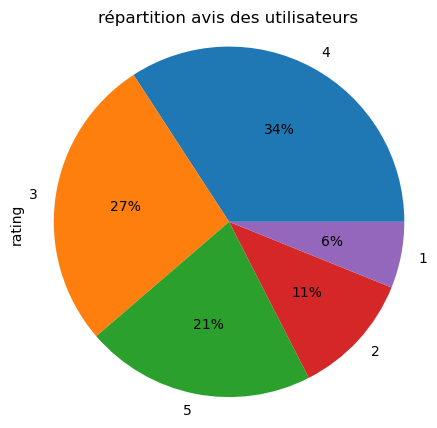

In [54]:
##############################################
# Répartition avis des utilisateurs          #
##############################################
afficher_pie_chart(df_in      = df_u_data, 
                   var_in     = 'rating',
                   title_in   = 'répartition avis des utilisateurs',
                   figsize_in = (5, 5))

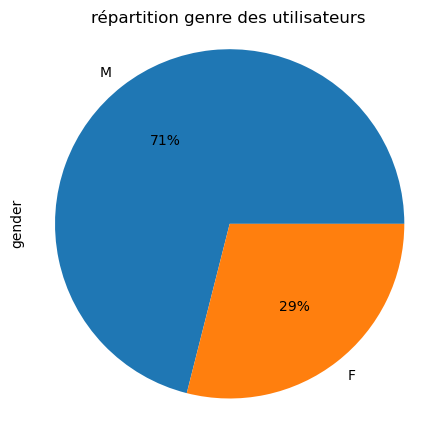

In [55]:
##############################################
# Répartition genre des utilisateurs         #
##############################################
afficher_pie_chart(df_in      = df_u_user, 
                   var_in     = 'gender',
                   title_in   = 'répartition genre des utilisateurs',
                   figsize_in = (5, 5))

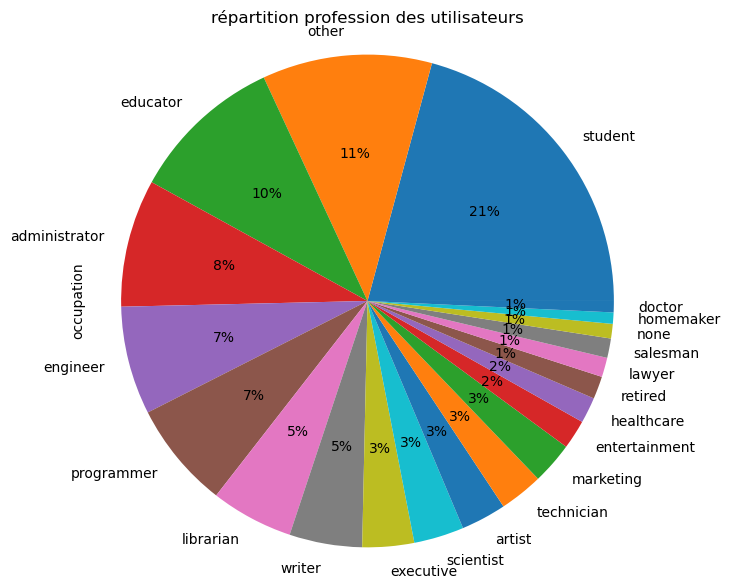

In [56]:
##############################################
# Répartition profession des utilisateurs    #
##############################################
afficher_pie_chart(df_in      = df_u_user, 
                   var_in     = 'occupation',
                   title_in   = 'répartition profession des utilisateurs',
                   figsize_in = (7, 7))

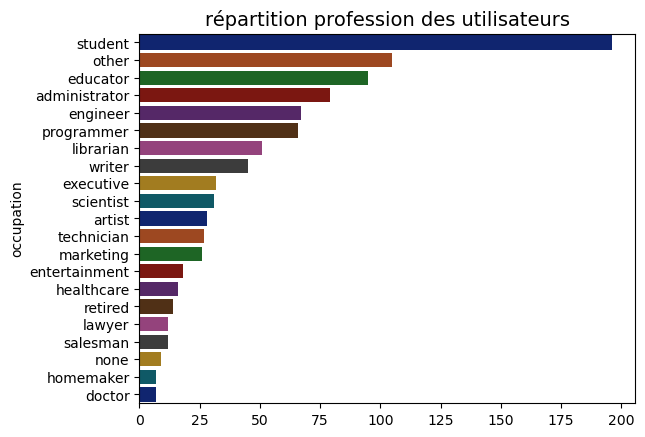

In [57]:
# https://www.kaggle.com/code/indralin/movielens-project-1-2-collaborative-filtering
occupation_counts = df_u_user['occupation'].value_counts().sort_values(ascending = False)

sns.barplot(x = occupation_counts.values,
            y = occupation_counts.index,
            palette = 'dark').set_title('répartition profession des utilisateurs', fontsize = 14)

plt.show()

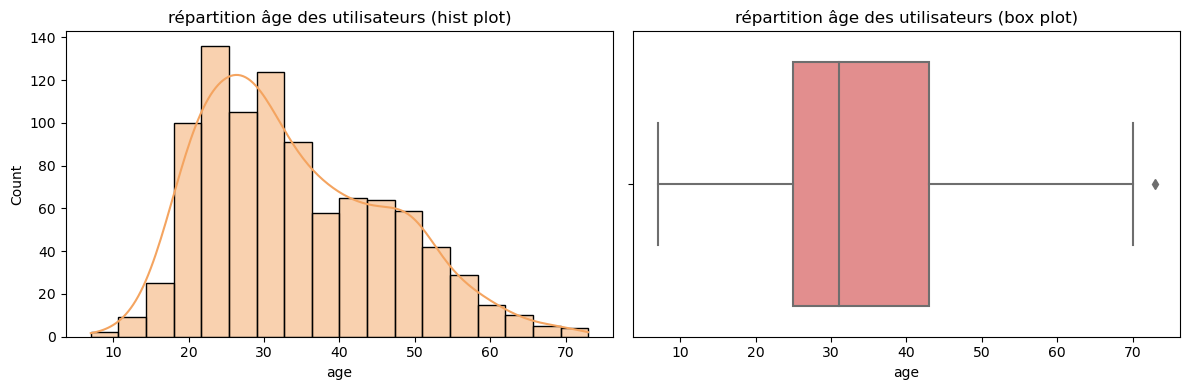

In [58]:
##############################################
# Répartition âge des utilisateurs           #
##############################################
afficher_histplot_boxplot_univariee(df_in    = df_u_user,
                                    var_in   = 'age',
                                    title_in = 'répartition âge des utilisateurs')

unknown : 1
Action : 248
Adventure : 133
Animation : 42
Children's : 120
Comedy : 502
Crime : 107
Documentary : 50
Drama : 715
Fantasy : 22
Film-Noir : 24
Horror : 90
Musical : 56
Mystery : 60
Romance : 244
Sci-Fi : 100
Thriller : 248
War : 71
Western : 27


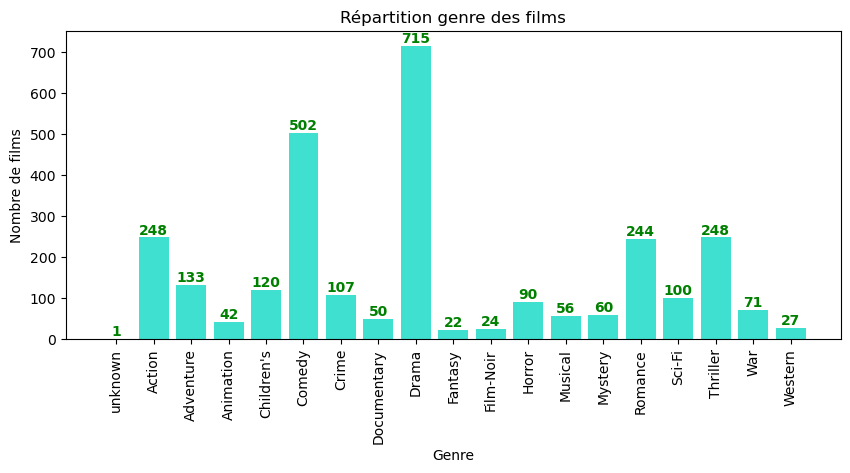

In [59]:
#############################################
# Répartition genre des films               #
#############################################
movie_sum_genre = []

for col in movie_liste_genre:
    print(col, ':', df_u_item[col].sum())
    movie_sum_genre.append(df_u_item[col].sum())


# Maj légende en haut des rectangles
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        if ( height != 0 ):
            ax.text(rect.get_x() + rect.get_width()/2, height,
                    '%d' % int(height),
                    ha = 'center', va = 'bottom', color = 'green', weight = 'bold')        


# create plot
fig, ax   = plt.subplots(figsize = (10, 4))  # (largeur, hauteur)
bar_width = 0.35
opacity   = 0.8

index = np.arange(len(movie_liste_genre_id))
rects = plt.bar(index, movie_sum_genre, align = 'center', color = 'turquoise')
plt.xlabel('Genre')
plt.xticks(index, movie_liste_genre, rotation = 90)
plt.ylabel('Nombre de films')
# Ajout scores en légende
autolabel(rects)
plt.title('Répartition genre des films')
plt.show()

In [ ]:
#########################################################
# Répartition période (année et mois) avis utilisateurs #
#########################################################

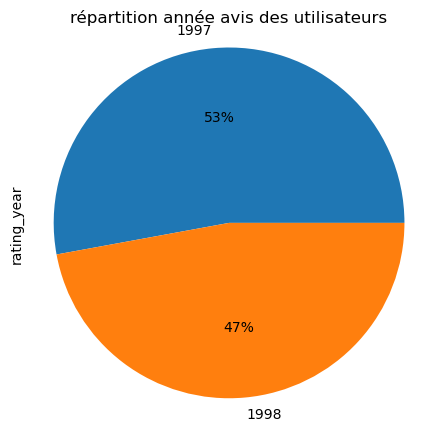

In [60]:
afficher_pie_chart(df_in      = df_u_data, 
                   var_in     = 'rating_year',
                   title_in   = 'répartition année avis des utilisateurs',
                   figsize_in = (5, 5))

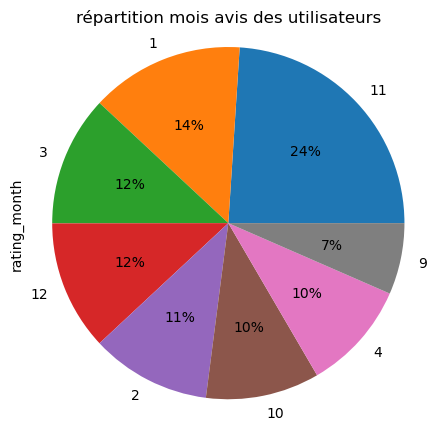

In [61]:
afficher_pie_chart(df_in      = df_u_data, 
                   var_in     = 'rating_month',
                   title_in   = 'répartition mois avis des utilisateurs',
                   figsize_in = (5, 5))

In [ ]:
# Notebooks intéressants pour d'autres schémas mais pas utilisés :
# https://www.kaggle.com/code/vibhumishra707/movielens-recommender-system
# https://www.kaggle.com/code/indralin/movielens-project-1-1-content-based
# https://www.kaggle.com/code/christine12/movielens-1m-dataset-python-pandas   

# 2.6. ANALYSE BIVARIEE

In [62]:
#############################################################
# Afficher hist plot & box plot.                            #
# Cas analyse bivariée : variable calculée dont on donne le #
#                        nom pour l'axe des x (xlabel_in)   #
#############################################################
def afficher_histplot_boxplot_bivariee(var_in, title_in, xlabel_in, ylabel_in):
    
    fig = plt.figure(figsize = (12, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(x = var_in, color = 'fuchsia', kde = True)    
    plt.title(title_in + ' (hist plot)')
    plt.xlabel(xlabel_in)
    plt.ylabel(ylabel_in)

    plt.subplot(1, 2, 2)
    sns.boxplot(x = var_in, color = 'lightpink') 
    plt.title(title_in + ' (box plot)')
    plt.xlabel(xlabel_in)
    plt.ylabel(ylabel_in)    

    fig.tight_layout()  # Espace entre les subplots
    plt.show()

In [63]:
#####################################################################
#   Box plot pour 1 variable catégorielle et 1 variable numérique   #
#####################################################################
def box_plot(colonne_x_numerique, colonne_y_categorielle, df_in):
    
    ordre_nutrition_grade = df_in.groupby(colonne_y_categorielle)[colonne_x_numerique].median().sort_values().index

    plt.figure(figsize     = (6, 6))
    sns.boxplot(x          = colonne_x_numerique, 
                y          = colonne_y_categorielle, 
                showfliers = False, # on supprime outliers
                orient     = 'h', 
                order      = ordre_nutrition_grade, 
                data       = df_in)
    
    plt.title('Box plot ' + colonne_x_numerique + ' % ' + colonne_y_categorielle)
#    plt.xlabel(colonne_x)
#    plt.ylabel(colonne_y_categorielle)
    plt.show()

In [ ]:
#############################################
# Répartition nombre de films / utilisateur #
#############################################

In [64]:
# id user
user_liste_id   = df_u_data['user_id'].unique().tolist()
print(len(user_liste_id), 'users\n')

# Calcul du nombre de films pour chaque user
nb_movies_liste = []
for user_id in user_liste_id:
    df_u_data_per_user = df_u_data[df_u_data['user_id'] == user_id]
    nb_movies_per_user = len(df_u_data_per_user.index)
    nb_movies_liste.append(nb_movies_per_user)
    print('user_id', user_id, '\t:', nb_movies_per_user, '\tfilms')

943 users

user_id 196 	: 39 	films
user_id 186 	: 92 	films
user_id 22 	: 128 	films
user_id 244 	: 238 	films
user_id 166 	: 20 	films
user_id 298 	: 127 	films
user_id 115 	: 92 	films
user_id 253 	: 97 	films
user_id 305 	: 222 	films
user_id 6 	: 211 	films
user_id 62 	: 232 	films
user_id 286 	: 288 	films
user_id 200 	: 216 	films
user_id 210 	: 132 	films
user_id 224 	: 141 	films
user_id 303 	: 484 	films
user_id 122 	: 61 	films
user_id 194 	: 305 	films
user_id 291 	: 296 	films
user_id 234 	: 480 	films
user_id 119 	: 181 	films
user_id 167 	: 69 	films
user_id 299 	: 280 	films
user_id 308 	: 397 	films
user_id 95 	: 278 	films
user_id 38 	: 121 	films
user_id 102 	: 216 	films
user_id 63 	: 93 	films
user_id 160 	: 120 	films
user_id 50 	: 24 	films
user_id 301 	: 275 	films
user_id 225 	: 27 	films
user_id 290 	: 150 	films
user_id 97 	: 63 	films
user_id 157 	: 51 	films
user_id 181 	: 435 	films
user_id 278 	: 23 	films
user_id 276 	: 518 	films
user_id 7 	: 403 	films

user_id 648 	: 297 	films
user_id 647 	: 58 	films
user_id 650 	: 311 	films
user_id 651 	: 21 	films
user_id 654 	: 147 	films
user_id 653 	: 283 	films
user_id 655 	: 685 	films
user_id 649 	: 24 	films
user_id 658 	: 71 	films
user_id 656 	: 24 	films
user_id 660 	: 224 	films
user_id 659 	: 191 	films
user_id 646 	: 38 	films
user_id 663 	: 158 	films
user_id 664 	: 166 	films
user_id 657 	: 29 	films
user_id 665 	: 142 	films
user_id 666 	: 245 	films
user_id 661 	: 121 	films
user_id 662 	: 23 	films
user_id 667 	: 47 	films
user_id 641 	: 40 	films
user_id 668 	: 46 	films
user_id 673 	: 35 	films
user_id 671 	: 124 	films
user_id 669 	: 100 	films
user_id 676 	: 77 	films
user_id 674 	: 41 	films
user_id 652 	: 22 	films
user_id 677 	: 49 	films
user_id 682 	: 399 	films
user_id 679 	: 62 	films
user_id 684 	: 86 	films
user_id 685 	: 20 	films
user_id 683 	: 75 	films
user_id 691 	: 32 	films
user_id 672 	: 29 	films
user_id 692 	: 40 	films
user_id 690 	: 115 	films
user_id 6

In [65]:
min_nb_movies  = min(nb_movies_liste)
mean_nb_movies = statistics.mean(nb_movies_liste)
max_nb_movies  = max(nb_movies_liste)

print('min_nb_movies\t=', min_nb_movies, 
      '\nmean_nb_movies\t=', round(mean_nb_movies, 2), 
      '\nmax_nb_movies\t=', max_nb_movies)

min_nb_movies	= 20 
mean_nb_movies	= 106.04 
max_nb_movies	= 737


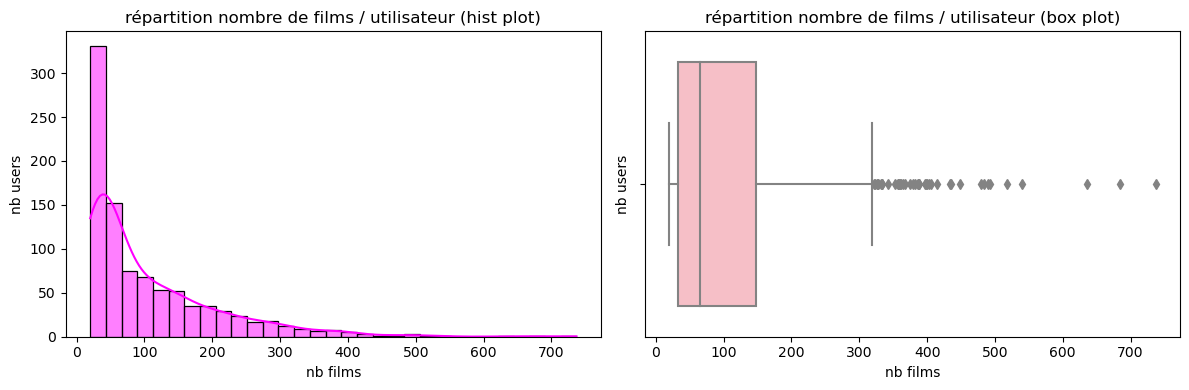

In [66]:
afficher_histplot_boxplot_bivariee(var_in    = nb_movies_liste, 
                                   title_in  = 'répartition nombre de films / utilisateur', 
                                   xlabel_in = 'nb films',
                                   ylabel_in = 'nb users')

In [ ]:
####################################################
# Répartition nombre d'avis (utilisateurs) / film  #
####################################################

In [67]:
# id films
movie_liste_id = df_u_data['item_id'].unique().tolist()
print(len(movie_liste_id), 'films\n')

# Calcul du nombre d'avis (utilisateurs) pour chaque film
nb_users_liste = []
for movie_id in movie_liste_id:
    df_u_data_per_movie = df_u_data[df_u_data['item_id'] == movie_id]
    nb_users_per_movie = len(df_u_data_per_movie.index)
    nb_users_liste.append(nb_users_per_movie)
    print('movie_id', movie_id, '\t:', nb_users_per_movie, '\tusers')

1664 films

movie_id 242 	: 117 	users
movie_id 302 	: 297 	users
movie_id 377 	: 13 	users
movie_id 51 	: 81 	users
movie_id 346 	: 126 	users
movie_id 474 	: 194 	users
movie_id 265 	: 227 	users
movie_id 465 	: 85 	users
movie_id 451 	: 170 	users
movie_id 86 	: 150 	users
movie_id 257 	: 303 	users
movie_id 1014 	: 98 	users
movie_id 222 	: 365 	users
movie_id 40 	: 57 	users
movie_id 29 	: 114 	users
movie_id 785 	: 39 	users
movie_id 387 	: 65 	users
movie_id 274 	: 190 	users
movie_id 1042 	: 28 	users
movie_id 1184 	: 10 	users
movie_id 392 	: 68 	users
movie_id 486 	: 64 	users
movie_id 144 	: 243 	users
movie_id 118 	: 293 	users
movie_id 1 	: 452 	users
movie_id 546 	: 254 	users
movie_id 95 	: 219 	users
movie_id 768 	: 52 	users
movie_id 277 	: 71 	users
movie_id 234 	: 280 	users
movie_id 246 	: 379 	users
movie_id 98 	: 390 	users
movie_id 193 	: 157 	users
movie_id 88 	: 213 	users
movie_id 194 	: 241 	users
movie_id 1081 	: 8 	users
movie_id 603 	: 209 	users
movie_id 

movie_id 463 	: 71 	users
movie_id 122 	: 106 	users
movie_id 310 	: 145 	users
movie_id 285 	: 162 	users
movie_id 447 	: 121 	users
movie_id 412 	: 93 	users
movie_id 1428 	: 12 	users
movie_id 977 	: 49 	users
movie_id 1065 	: 53 	users
movie_id 421 	: 106 	users
movie_id 937 	: 37 	users
movie_id 583 	: 37 	users
movie_id 110 	: 31 	users
movie_id 251 	: 46 	users
movie_id 831 	: 91 	users
movie_id 543 	: 21 	users
movie_id 926 	: 101 	users
movie_id 155 	: 98 	users
movie_id 53 	: 128 	users
movie_id 393 	: 192 	users
movie_id 91 	: 143 	users
movie_id 477 	: 95 	users
movie_id 472 	: 158 	users
movie_id 761 	: 44 	users
movie_id 1286 	: 17 	users
movie_id 93 	: 112 	users
movie_id 644 	: 35 	users
movie_id 982 	: 20 	users
movie_id 491 	: 67 	users
movie_id 511 	: 173 	users
movie_id 397 	: 12 	users
movie_id 162 	: 106 	users
movie_id 513 	: 72 	users
movie_id 375 	: 23 	users
movie_id 38 	: 120 	users
movie_id 418 	: 129 	users
movie_id 858 	: 3 	users
movie_id 131 	: 95 	users

movie_id 362 	: 28 	users
movie_id 1442 	: 5 	users
movie_id 1419 	: 16 	users
movie_id 1241 	: 6 	users
movie_id 613 	: 27 	users
movie_id 656 	: 44 	users
movie_id 734 	: 27 	users
movie_id 946 	: 61 	users
movie_id 913 	: 2 	users
movie_id 1172 	: 15 	users
movie_id 1108 	: 5 	users
movie_id 1347 	: 4 	users
movie_id 1074 	: 77 	users
movie_id 1187 	: 13 	users
movie_id 856 	: 36 	users
movie_id 1212 	: 6 	users
movie_id 1105 	: 18 	users
movie_id 6 	: 26 	users
movie_id 964 	: 9 	users
movie_id 1043 	: 8 	users
movie_id 398 	: 26 	users
movie_id 694 	: 44 	users
movie_id 1072 	: 7 	users
movie_id 1141 	: 9 	users
movie_id 733 	: 15 	users
movie_id 1051 	: 41 	users
movie_id 1478 	: 18 	users
movie_id 19 	: 69 	users
movie_id 1210 	: 38 	users
movie_id 962 	: 23 	users
movie_id 1203 	: 21 	users
movie_id 563 	: 29 	users
movie_id 1097 	: 18 	users
movie_id 1292 	: 3 	users
movie_id 458 	: 90 	users
movie_id 871 	: 75 	users
movie_id 1062 	: 12 	users
movie_id 608 	: 30 	users
movie_

In [68]:
min_nb_users  = min(nb_users_liste)
mean_nb_users = statistics.mean(nb_users_liste)
max_nb_users  = max(nb_users_liste)

print('min_nb_users\t=', min_nb_users, 
      '\nmean_nb_users\t=', round(mean_nb_users, 2), 
      '\nmax_nb_users\t=', max_nb_users)

min_nb_users	= 1 
mean_nb_users	= 60.1 
max_nb_users	= 583


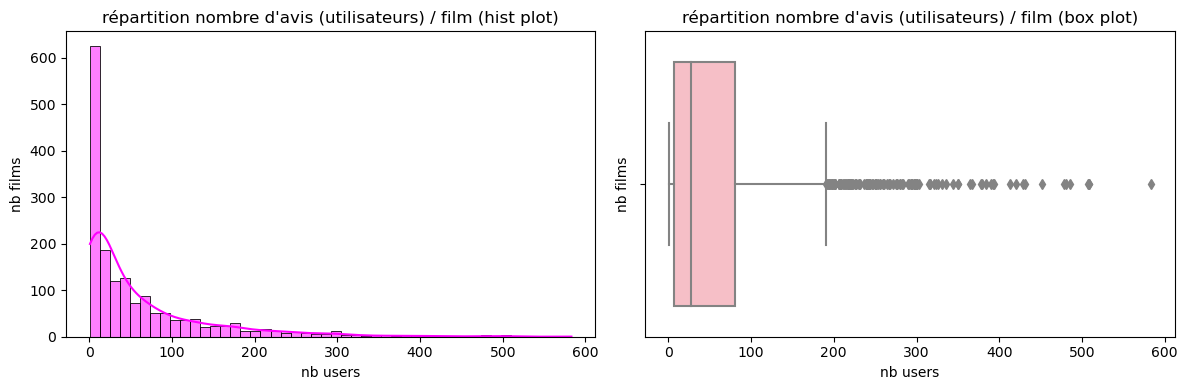

In [69]:
afficher_histplot_boxplot_bivariee(var_in    = nb_users_liste, 
                                   title_in  = 'répartition nombre d\'avis (utilisateurs) / film', 
                                   xlabel_in = 'nb users',
                                   ylabel_in = 'nb films')

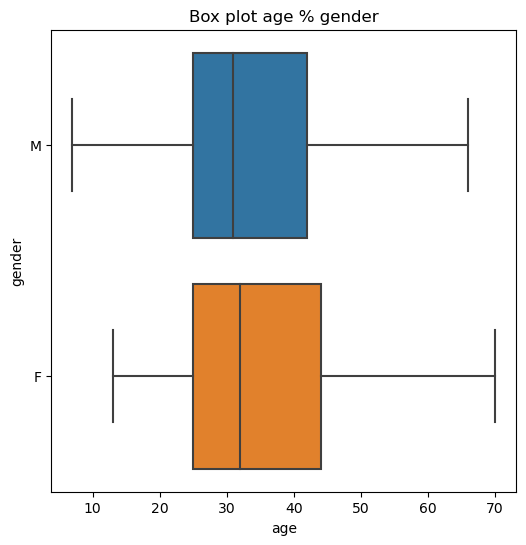

In [70]:
####################################################
# Répartition âge % genre                          #
####################################################
box_plot(colonne_x_numerique    = 'age', 
         colonne_y_categorielle = 'gender',
         df_in                  = df_u_user)

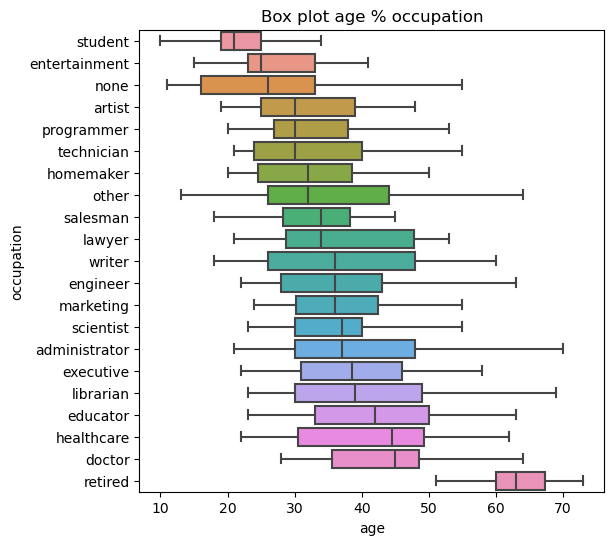

In [71]:
####################################################
# Répartition âge % profession                     #
####################################################
box_plot(colonne_x_numerique    = 'age', 
         colonne_y_categorielle = 'occupation',
         df_in                  = df_u_user)

# 3. BASELINE : RANDOM RECOMMENDER SYSTEM

In [ ]:
# https://towardsdatascience.com/movielens-1m-deep-dive-part-i-8acfeda1ad4

In [73]:
# We create and standard two dataset splits : train / test splits. 
reader = Reader(rating_scale = (1, 5))
data   = Dataset.load_from_df(df_u_data[['user_id', 'item_id', 'rating']], reader)

trainset, testset = train_test_split(data, test_size = 0.25)

In [74]:
# We calculate RMSE on test set
def get_algo_results(algo, trainset, testset):
    algo.fit(trainset)
    predictions = algo.test(testset)
    accuracy.rmse(predictions)
    accuracy.mae(predictions)    

In [75]:
# Let’s obtain results for a completely random recommender system, so we will be able to evaluate if our algorithms are
# better or worse than random (after all, we want to make things better not worse…)

# https://ichi.pro/fr/une-approche-simple-pour-creer-un-systeme-de-recommandation-229750116851536
# Autrement dit, NormalPredictor : un modèle de base qui prédit une évaluation aléatoire basée sur la distribution de
# l'ensemble d'apprentissage, qui est supposée être normale.
normal_predictor = NormalPredictor()

get_algo_results(normal_predictor, trainset, testset)  

RMSE: 1.5153
MAE:  1.2160


# 4. RECOMMENDING MOVIES WITH COLLABORATIVE FILTERING

In [ ]:
# https://realpython.com/build-recommendation-engine-collaborative-filtering/#using-python-to-build-recommenders

# 4.1. MEMORY-BASED RECOMMENDATION SYSTEM (AVEC SURPRISE)

In [ ]:
# For the memory-based approaches, the algorithm that would fit the bill is Centered k-NN because the algorithm is very 
# close to the centered cosine similarity formula explained above. It is available in Surprise as KNNWithMeans.

In [76]:
data = Dataset.load_builtin('ml-100k')

# To find the similarity, you simply have to configure the function by passing a dictionary as an argument to the 
# recommender function. 

# The dictionary should have the required keys, such as the following:

               # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
               # @ name : contains the similarity metric to use.                                                       @
               # @        Options are cosine, msd, pearson, or pearson_baseline. The default is msd.                   @
               # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
sim_options = {'name': ['msd', 'cosine'],   
               # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
               # @ min_support : is the minimum number of common items needed between users to consider them for       @
               # @               similarity.                                                                           @
               # @               For the item-based approach, this corresponds to the minimum number of common users   @
               # @               for two items.                                                                        @
               # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
               'min_support': [3, 4, 5],   
               
               # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
               # @ user_based : is a boolean that tells whether the approach will be user-based or item-based.         @
               # @              The default is True, which means the user-based approach will be used.                 @
               # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
               'user_based': [False, True]}

param_grid_memory_based = {'sim_options': sim_options}

# KNNWithMeans is basic collaborative filtering algorithm, taking into account the mean ratings of each user.
gs_memory_based = GridSearchCV(KNNWithMeans, 
                               param_grid_memory_based, 
                               measures = ['rmse', 'mae'], 
                               cv       = 3)

gs_memory_based.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [77]:
print('best_score =', gs_memory_based.best_score)

best_score = {'rmse': 0.9437390847366034, 'mae': 0.739868529143663}


In [78]:
print('Memory-based approache :')
print('\tRMSE / best_score\t=', round(gs_memory_based.best_score['rmse'], 4))
print('\tRMSE / best_params\t=', gs_memory_based.best_params['rmse'])
print('\t MAE / best_score\t=', round(gs_memory_based.best_score['mae'], 4))
print('\t MAE / best_params\t=', gs_memory_based.best_params['mae'])

# ==> For the MovieLens 100k dataset, Centered-KNN algorithm works best with the following parameters :
#    --> with item-based approach.
#    --> msd as the similarity metric.
#    --> minimum support 3.

Memory-based approache :
	RMSE / best_score	= 0.9437
	RMSE / best_params	= {'sim_options': {'name': 'msd', 'min_support': 3, 'user_based': False}}
	 MAE / best_score	= 0.7399
	 MAE / best_params	= {'sim_options': {'name': 'msd', 'min_support': 3, 'user_based': False}}


# 4.2. MODEL-BASED RECOMMENDATION SYSTEM

# 4.2.1. MATRIX FACTORISATION (AVEC SURPRISE)

In [ ]:
# The following program will check the best values for the SVD algorithm, which is a matrix factorization algorithm :

In [79]:
data = Dataset.load_builtin('ml-100k')

# For model-based approaches, we can use Surprise to check which values for the following factors work best :

                          # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
                          # @ n_epochs : is the number of iterations of SGD, which is basically an iterative method     @ 
                          # @            used in statistics to minimize a function.                                     @
                          # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
param_grid_model_based = {'n_epochs': [5, 10],
                          
                          # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
                          # @ lr_all : is the learning rate for all parameters, which is a parameter that decides how   @
                          # @          much the parameters are adjusted in each iteration.                              @
                          # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
                          'lr_all': [0.002, 0.005],
                          
                          # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
                          # @ reg_all : is the regularization term for all parameters, which is a penalty term added    @
                          # @           to prevent overfitting.                                                         @
                          # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
                          'reg_all': [0.4, 0.6]}

gs_model_based = GridSearchCV(SVD, 
                              param_grid_model_based, 
                              measures = ['rmse', 'mae'], 
                              cv       = 3)

gs_model_based.fit(data)

In [80]:
print('best_score =', gs_model_based.best_score)

best_score = {'rmse': 0.9636639950705631, 'mae': 0.7722712852913651}


In [81]:
print('Model-based approache :')
print('\tRMSE / best_score\t=', round(gs_model_based.best_score['rmse'], 4))
print('\tRMSE / best_params\t=', gs_model_based.best_params['rmse'])
print('\t MAE / best_score\t=', round(gs_model_based.best_score['mae'], 4))
print('\t MAE / best_params\t=', gs_model_based.best_params['mae'])

# => For the MovieLens 100k dataset, the SVD algorithm works best with the following parameters :
#    --> 10 epochs.
#    --> learning rate of 0.005.
#    --> 0.4 regularization.

Model-based approache :
	RMSE / best_score	= 0.9637
	RMSE / best_params	= {'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}
	 MAE / best_score	= 0.7723
	 MAE / best_params	= {'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


# 4.2.2. AUTO-ENCODERS

In [ ]:
# https://towardsdatascience.com/recommendation-system-series-part-6-the-6-variants-of-autoencoders-for-collaborative-filtering-bd7b9eae2ec7
#
# http://users.cecs.anu.edu.au/~akmenon/papers/autorec/autorec-paper.pdf : 
# AutoRec model, a recently-proposed autoencoder framework for collaborative filtering.

In [82]:
batch_size = 512

In [83]:
# Let's first create a custom dataset that will allow us to train the model.
# The custom dataset should inherit the Dataset class of PyTorch and override the following methods :
#   --> __len__.
#   --> __getitem__. 
# We will create a dataset class for the MovieLens dataset. 
# We will read the df_train dataframe and produce the user-item matrix in __init__. 
class MovieLens100KTrainDatasetAutoRec(Dataset):
    
    def __init__(self, df_train):
        data = df_train.to_numpy()[:, :3]
    
        users   = data[:,0].astype(int) - 1
        movies  = data[:,1].astype(int) - 1        
        targets = data[:, 2].astype(np.float32)    
        
        self.n_users = np.max(users) + 1
        self.n_movies = np.max(movies) + 1
        self.R = np.zeros((self.n_users, self.n_movies), dtype = np.float32)
        for i in range(targets.size):
            self.R[users[i], movies[i]] = targets[i]

    # we override the __len__ method, so that len(dataset) returns the size of the dataset.
    def __len__(self):
        return self.n_movies

    # We override the __getitem__ method, to support the indexing such that dataset[i] can be used to get the 𝑖𝑡ℎ sample.
    # Since each sample correponds to the representation of an item, the __getitem__ function will return a specific
    # column of the user-item matrix.    
    def __getitem__(self, index):
        return self.R[:,index]

In [84]:
# We create an iterable over the training set of the MovieLens dataset (u1.base).
train_set_AutoRec_1 = MovieLens100KTrainDatasetAutoRec(df_train = df_u1_base)

# We use the DataLoader class, an iterator that allows us to batch the data, shuffle the data and load the data in
# parallel using multiprocessing workers.
train_loader_AutoRec_1 = DataLoader(train_set_AutoRec_1, batch_size = batch_size)

In [85]:
# We create an iterable over the training set of the MovieLens dataset (u2.base).
train_set_AutoRec_2 = MovieLens100KTrainDatasetAutoRec(df_train = df_u2_base)

# We use the DataLoader class, an iterator that allows us to batch the data, shuffle the data and load the data in
# parallel using multiprocessing workers.
train_loader_AutoRec_2 = DataLoader(train_set_AutoRec_2, batch_size = batch_size)

In [86]:
# We create an iterable over the training set of the MovieLens dataset (u3.base).
train_set_AutoRec_3 = MovieLens100KTrainDatasetAutoRec(df_train = df_u3_base)

# We use the DataLoader class, an iterator that allows us to batch the data, shuffle the data and load the data in
# parallel using multiprocessing workers.
train_loader_AutoRec_3 = DataLoader(train_set_AutoRec_3, batch_size = batch_size)

In [87]:
# We create an iterable over the training set of the MovieLens dataset (u4.base).
train_set_AutoRec_4 = MovieLens100KTrainDatasetAutoRec(df_train = df_u4_base)

# We use the DataLoader class, an iterator that allows us to batch the data, shuffle the data and load the data in
# parallel using multiprocessing workers.
train_loader_AutoRec_4 = DataLoader(train_set_AutoRec_4, batch_size = batch_size)

In [88]:
# We create an iterable over the training set of the MovieLens dataset (u5.base).
train_set_AutoRec_5 = MovieLens100KTrainDatasetAutoRec(df_train = df_u5_base)

# We use the DataLoader class, an iterator that allows us to batch the data, shuffle the data and load the data in
# parallel using multiprocessing workers.
train_loader_AutoRec_5 = DataLoader(train_set_AutoRec_5, batch_size = batch_size)

In [89]:
#########################################################################
# AutoRec model architecture with the following layers :                #
#   --> a fully-connected layer with ℎ hidden units followed by a       #
#       sigmoid activation function.                                    #
#   --> a dropout layer with with 𝑝𝑑 ratio of dropped outputs.          #
#   --> a fully-connected layer with 𝑚 units followed by no activation #
#       function.                                                       #
#########################################################################
class AutoRec(torch.nn.Module):
    
    def __init__(self, n_users, hidden_dim, dropout):
        super(AutoRec, self).__init__()
        self.fc1 = nn.Linear(n_users, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, n_users)
        
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        z = self.sigmoid(self.fc1(x))
        z = self.dropout(z)
        z = self.fc2(z)
        
        return z

In [90]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

epochs = 50

In [93]:
#########################################################################
# Model training :                                                      #
# on the training data of the MovieLens dataset.                        #
#########################################################################
def AutoRec_model_training(train_set, train_loader, dataset_number):
    
    print('AutoRec_model_training - dataset_number =', dataset_number, ':')
    
    n_users = train_set.n_users

    # We initialize an AutoRec model :
    #    --> the dimensionality of the hidden layer to 256,
    #    --> the dropout rate to 0.2.
    model = AutoRec(n_users    = n_users,
                    hidden_dim = 256, 
                    dropout    = 0.2).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr = 0.001)

    
    # We initialize the Loss function.
    loss_function = nn.MSELoss()

    
    # We train the model on 50 epochs.
    for epoch in range(epochs):
        t = time.time()
        
        model.train()
        
        train_loss = 0
        count      = 0
        
        for x in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = loss_function(output[x > 0], x[x > 0])
            train_loss += loss.item() * output[x > 0].size(0)
            count += output[x > 0].size(0)
            loss.backward()
            optimizer.step()

        if (epoch % 10 == 0): 
            print('\tEpoch : {:04d}'.format(epoch + 1),
                  ',\tloss_train : {:.4f}'.format(train_loss / count),
                  '\ttime : {:.4f}s'.format(time.time() - t))
            
    return model

In [94]:
model_AutoRec_1 = AutoRec_model_training(train_set      = train_set_AutoRec_1,
                                         train_loader   = train_loader_AutoRec_1,
                                         dataset_number = 1)

AutoRec_model_training - dataset_number = 1 :
	Epoch : 0001 ,	loss_train : 13.4304 	time : 0.0667s
	Epoch : 0011 ,	loss_train : 1.3073 	time : 0.0782s
	Epoch : 0021 ,	loss_train : 1.0434 	time : 0.0786s
	Epoch : 0031 ,	loss_train : 0.9409 	time : 0.0776s
	Epoch : 0041 ,	loss_train : 0.8829 	time : 0.0788s


In [95]:
model_AutoRec_2 = AutoRec_model_training(train_set      = train_set_AutoRec_2,
                                         train_loader   = train_loader_AutoRec_2,
                                         dataset_number = 2)                                 

AutoRec_model_training - dataset_number = 2 :
	Epoch : 0001 ,	loss_train : 13.5318 	time : 0.0705s
	Epoch : 0011 ,	loss_train : 1.3583 	time : 0.0685s
	Epoch : 0021 ,	loss_train : 1.0749 	time : 0.0771s
	Epoch : 0031 ,	loss_train : 0.9682 	time : 0.0626s
	Epoch : 0041 ,	loss_train : 0.8951 	time : 0.0782s


In [96]:
model_AutoRec_3 = AutoRec_model_training(train_set      = train_set_AutoRec_3,
                                         train_loader   = train_loader_AutoRec_3,
                                         dataset_number = 3)                                 

AutoRec_model_training - dataset_number = 3 :
	Epoch : 0001 ,	loss_train : 13.5350 	time : 0.0654s
	Epoch : 0011 ,	loss_train : 1.3477 	time : 0.0715s
	Epoch : 0021 ,	loss_train : 1.0516 	time : 0.0625s
	Epoch : 0031 ,	loss_train : 0.9531 	time : 0.0789s
	Epoch : 0041 ,	loss_train : 0.8895 	time : 0.0743s


In [97]:
model_AutoRec_4 = AutoRec_model_training(train_set      = train_set_AutoRec_4,
                                         train_loader   = train_loader_AutoRec_4,
                                         dataset_number = 4)                                 

AutoRec_model_training - dataset_number = 4 :
	Epoch : 0001 ,	loss_train : 13.5947 	time : 0.0871s
	Epoch : 0011 ,	loss_train : 1.3203 	time : 0.0700s
	Epoch : 0021 ,	loss_train : 1.0575 	time : 0.0781s
	Epoch : 0031 ,	loss_train : 0.9541 	time : 0.0788s
	Epoch : 0041 ,	loss_train : 0.8939 	time : 0.0793s


In [98]:
model_AutoRec_5 = AutoRec_model_training(train_set      = train_set_AutoRec_5,
                                         train_loader   = train_loader_AutoRec_5,
                                         dataset_number = 5)                                 

AutoRec_model_training - dataset_number = 5 :
	Epoch : 0001 ,	loss_train : 13.6137 	time : 0.0815s
	Epoch : 0011 ,	loss_train : 1.3112 	time : 0.0731s
	Epoch : 0021 ,	loss_train : 1.0550 	time : 0.0789s
	Epoch : 0031 ,	loss_train : 0.9565 	time : 0.0786s
	Epoch : 0041 ,	loss_train : 0.8960 	time : 0.0845s


In [112]:
#########################################################################
# Model evaluation :                                                    #
# on new, previously unseen data (test set).                            #
#########################################################################
def AutoRec_model_evaluation(train_set, df_test, model, dataset_number):
    
    # We load the test data.
    test_data = df_test.to_numpy()[:, :3]

    users = test_data[:,0].astype(int) - 1
    movies = test_data[:,1].astype(int) - 1
    y_test = test_data[:, 2].astype(np.float32)

    
    # We use the model to make predictions for the user-movie pairs of the test set.
    model.eval()

    y_pred = list()
    
    try:
        for i in range(y_test.size):
            x = train_set.R[:,movies[i]]
            x = torch.FloatTensor(x)
            x = x.to(device)
            output = model(x)
        
            # We store the predictions into a NumPy vector.
            y_pred.append(output[users[i]].detach().cpu().numpy())
        
    except IndexError:
        print('Exception ******* IndexError : index xxx is out of bounds for axis 1 with size yyyy\n')
        # Ajustement taille y_test sur celle de y_pred
        y_test = y_test[0:len(y_pred)]
        
    # We compute the root mean squared error to evaluate the AutoRec model.
    rmse = round(mean_squared_error(y_test, y_pred, squared = False), 4)
    mae  = round(mean_absolute_error(y_test, y_pred), 4)
    
    print('RMSE AutoRec_' + str(dataset_number), ':', rmse)
    print(' MAE AutoRec_' + str(dataset_number), ':', mae)
    
    return rmse, mae

In [113]:
rmse_AutoRec_1, mae_AutoRec_1 = AutoRec_model_evaluation(train_set      = train_set_AutoRec_1,
                                                         df_test        = df_u1_test, 
                                                         model          = model_AutoRec_1,
                                                         dataset_number = 1)

RMSE AutoRec_1 : 0.9494
 MAE AutoRec_1 : 0.7472


In [114]:
rmse_AutoRec_2, mae_AutoRec_2 = AutoRec_model_evaluation(train_set      = train_set_AutoRec_2,
                                                         df_test        = df_u2_test, 
                                                         model          = model_AutoRec_2,
                                                         dataset_number = 2)

RMSE AutoRec_2 : 0.9395
 MAE AutoRec_2 : 0.7388


In [115]:
rmse_AutoRec_3, mae_AutoRec_3 = AutoRec_model_evaluation(train_set      = train_set_AutoRec_3,
                                                         df_test        = df_u3_test, 
                                                         model          = model_AutoRec_3,
                                                         dataset_number = 3)

RMSE AutoRec_3 : 0.939
 MAE AutoRec_3 : 0.7399


In [116]:
rmse_AutoRec_4, mae_AutoRec_4 = AutoRec_model_evaluation(train_set      = train_set_AutoRec_4,
                                                         df_test        = df_u4_test, 
                                                         model          = model_AutoRec_4,
                                                         dataset_number = 4)

RMSE AutoRec_4 : 0.9447
 MAE AutoRec_4 : 0.7459


In [117]:
rmse_AutoRec_5, mae_AutoRec_5 = AutoRec_model_evaluation(train_set      = train_set_AutoRec_5,
                                                         df_test        = df_u5_test, 
                                                         model          = model_AutoRec_5, 
                                                         dataset_number = 5)

Exception ******* IndexError : index xxx is out of bounds for axis 1 with size yyyy

RMSE AutoRec_5 : 0.9438
 MAE AutoRec_5 : 0.7478


In [118]:
#########################################################################
# Mean of the RMSE & MAE                                                #
#########################################################################
# https://www.delftstack.com/fr/howto/python/get-average-of-list-python/
rmse_AutoRec_mean = statistics.mean([rmse_AutoRec_1, rmse_AutoRec_2, rmse_AutoRec_3, rmse_AutoRec_4, rmse_AutoRec_5])
mae_AutoRec_mean  = statistics.mean([mae_AutoRec_1, mae_AutoRec_2, mae_AutoRec_3, mae_AutoRec_4, mae_AutoRec_5])

print('RMSE AutoRec_mean =', round(rmse_AutoRec_mean, 4))
print(' MAE AutoRec_mean =', round(mae_AutoRec_mean, 4))

RMSE AutoRec_mean = 0.9433
 MAE AutoRec_mean = 0.7439


# 4.2.3. NEURAL NETWORK

In [ ]:
# https://github.com/chenxd2/MovieLens-Hybrid-Movie-Recommendation-System/blob/main/NCF-model.ipynb
#
# https://arxiv.org/pdf/1708.05031.pdf : NCF (Neural Collaborative Filtering) neural network, a model that generalizes 
# the factorization approaches by replacing the inner product with a neural architecture that can learn an arbitrary 
# function from data.

In [ ]:
# Most recently-developed recommender systems are instances of the collaborative filtering with implicit feedback approach.
# These systems resort to matrix factorization to generate latent features of users and items, and then apply an inner 
# product on these latent features to capture the interactions between users and items. The Neural Collaborative Filtering 
# model replaces the inner product with a neural architecture that can learn an arbitrary function from data.

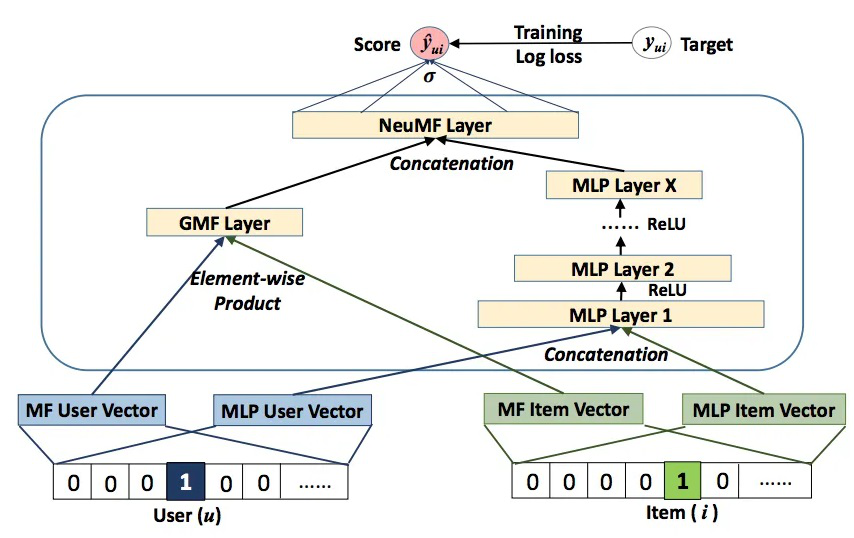

In [119]:
########################################
# NCF Architecture                     #
########################################
# https://medium.com/data-science-in-your-pocket/recommendation-systems-using-neural-collaborative-filtering-ncf-explained-with-codes-21a97e48a2f7
# https://towardsdatascience.com/neural-collaborative-filtering-96cef1009401
Image.open('./images/NCF_architecture.jpg')

In [120]:
# Let's again create a custom dataset. 
# Therefore, we will next use some tools provided by PyTorch to load the data in an easy manner. 
#   --> __len__.
#   --> __getitem__. This function of our dataset returns a triplet :
#         (1) the id of the user.
#         (2) the id of the item.
#         (3) the rating that the user gave to the item.
#   Because the Neural Collaborative Filtering model takes the id of a user and of an item as input, and predicts the 
#   rating that the user would give to the item.
#
# The following class represents the MovieLens dataset.
class MovieLens100KDatasetNCF(Dataset):

    def __init__(self, df):
        data = df.to_numpy()[:, :3]        
        
        self.users = data[:,0].astype(int) - 1
        self.movies = data[:,1].astype(int) - 1
        self.targets = data[:, 2].astype(np.float32)
        
        self.n_users = np.max(self.users) + 1
        self.n_movies = np.max(self.movies) + 1

    def __len__(self):
        return self.targets.size

    def __getitem__(self, index):
        return self.users[index], self.movies[index], self.targets[index]

In [121]:
# We initialize two instances of the MovieLens dataset : u1.base for the training set and u1.test for the test set.
# Specifically, we will use the DataLoader class, an iterator that allows us to batch the data, shuffle the data and
# load the data in parallel using multiprocessing workers.
train_set_NCF_1 = MovieLens100KDatasetNCF(df = df_u1_base)
test_set_NCF_1  = MovieLens100KDatasetNCF(df = df_u1_test)

# We use the DataLoader class of PyTorch to combine the two datasets with a sampler.
train_loader_NCF_1 = DataLoader(train_set_NCF_1, batch_size = batch_size)
test_loader_NCF_1  = DataLoader(test_set_NCF_1, batch_size = batch_size)

In [122]:
# We initialize two instances of the MovieLens dataset : u2.base for the training set and u2.test for the test set.
# Specifically, we will use the DataLoader class, an iterator that allows us to batch the data, shuffle the data and
# load the data in parallel using multiprocessing workers.
train_set_NCF_2 = MovieLens100KDatasetNCF(df = df_u2_base)
test_set_NCF_2  = MovieLens100KDatasetNCF(df = df_u2_test)

# We use the DataLoader class of PyTorch to combine the two datasets with a sampler.
train_loader_NCF_2 = DataLoader(train_set_NCF_2, batch_size = batch_size)
test_loader_NCF_2  = DataLoader(test_set_NCF_2, batch_size = batch_size)

In [123]:
# We initialize two instances of the MovieLens dataset : u3.base for the training set and u3.test for the test set.
# Specifically, we will use the DataLoader class, an iterator that allows us to batch the data, shuffle the data and
# load the data in parallel using multiprocessing workers.
train_set_NCF_3 = MovieLens100KDatasetNCF(df = df_u3_base)
test_set_NCF_3  = MovieLens100KDatasetNCF(df = df_u3_test)

# We use the DataLoader class of PyTorch to combine the two datasets with a sampler.
train_loader_NCF_3 = DataLoader(train_set_NCF_3, batch_size = batch_size)
test_loader_NCF_3  = DataLoader(test_set_NCF_3, batch_size = batch_size)

In [124]:
# We initialize two instances of the MovieLens dataset : u4.base for the training set and u4.test for the test set.
# Specifically, we will use the DataLoader class, an iterator that allows us to batch the data, shuffle the data and
# load the data in parallel using multiprocessing workers.
train_set_NCF_4 = MovieLens100KDatasetNCF(df = df_u4_base)
test_set_NCF_4  = MovieLens100KDatasetNCF(df = df_u4_test)

# We use the DataLoader class of PyTorch to combine the two datasets with a sampler.
train_loader_NCF_4 = DataLoader(train_set_NCF_4, batch_size = batch_size)
test_loader_NCF_4  = DataLoader(test_set_NCF_4, batch_size = batch_size)

In [125]:
# We initialize two instances of the MovieLens dataset : u5.base for the training set and u5.test for the test set.
# Specifically, we will use the DataLoader class, an iterator that allows us to batch the data, shuffle the data and
# load the data in parallel using multiprocessing workers.
train_set_NCF_5 = MovieLens100KDatasetNCF(df = df_u5_base)
test_set_NCF_5  = MovieLens100KDatasetNCF(df = df_u5_test)

# We use the DataLoader class of PyTorch to combine the two datasets with a sampler.
train_loader_NCF_5 = DataLoader(train_set_NCF_5, batch_size = batch_size)
test_loader_NCF_5  = DataLoader(test_set_NCF_5, batch_size = batch_size)

In [ ]:
#################################################################################################################
# The NCF (Neural Collaborative Filtering) model consists of two branches :                                     #
#  (1) The GMF (Generalized Matrix Factorization) layer which allows the model to mimic a large family of       #
#      factorization models. For the GMF branch, we add the following layers :                                  #
#      ---> two embedding layers (one for users and one for items).                                             #
#      ---> a layer that computes the element-wise product between the representations of users and items.      #
#      ---> a dropout layer with with 𝑝𝑑 ratio of dropped outputs.                                              #
#                                                                                                               #
# (2) The MLP (Multi-Layer Perceptron) layer which combines the features of users and items by concatenating    #
#     them. For the MLP branch, add the following layers :                                                      #
#     ---> two embedding layers (one for users and one for items).                                              #
#     ---> a layer that concatenates the representations of the users with those of the items.                  #
#     ---> an MLP consisting of 𝐿 layers where each layer is followed by the ReLU activation function.          #
#     ---> a dropout layer with with 𝑝𝑑 ratio of dropped outputs.                                               #
#                                                                                                               #
# The two branches (GMF layer and MLP layer) are then merged and passed on to a fully connected layer which     #
# produces the output (predict the rating input users have given to input items).                               #
#                                                                                                               #
# Both GMF and MLP layers embed the input users and items into a vector space.                                  #
# The two layers do not share the same parameters. Instead, they generate different embeddings from each other. #
# The obtained embedding vectors can be seen as the latent features of users / items.                           #
# Furthermore, these embedding vectors are trainable.                                                           # 
#################################################################################################################

In [126]:
class NCF(torch.nn.Module):
    def __init__(self, n_users, n_items, embedding_dim_gmf, embedding_dim_mlp, n_layers, hidden_dim, dropout):
        super(NCF, self).__init__()
        self.n_layers = n_layers
        
        self.embedding_user_gmf = nn.Embedding(n_users, embedding_dim_gmf)
        self.embedding_item_gmf = nn.Embedding(n_items, embedding_dim_gmf)

        self.embedding_user_mlp = nn.Embedding(n_users, embedding_dim_mlp)
        self.embedding_item_mlp = nn.Embedding(n_items, embedding_dim_mlp)
        
        fc_layers = [nn.Linear(embedding_dim_mlp*2, hidden_dim)]
        for i in range(n_layers):
            fc_layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.mlp = nn.ModuleList(fc_layers)
        
        self.fc = nn.Linear(hidden_dim+embedding_dim_gmf, 1)
        
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()


    def forward(self, user_indices, item_indices):
        # GMF layer
        p_gmf = self.embedding_user_gmf(user_indices)
        q_gmf = self.embedding_item_gmf(item_indices)

        x_gmf = torch.mul(p_gmf, q_gmf)
      
        # MLP layer
        p_mlp = self.embedding_user_mlp(user_indices)
        q_mlp = self.embedding_item_mlp(item_indices)

        pq_mlp = torch.cat([p_mlp, q_mlp], dim=1)

        for i in range(self.n_layers):
            pq_mlp = self.relu(self.mlp[i](pq_mlp))

        x_mlp = self.dropout(pq_mlp)

        # Merged layer
        out = torch.cat([x_gmf, x_mlp], dim=1)
        out = self.fc(out)
        
        return out.squeeze()

In [127]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

epochs = 50

In [128]:
#########################################################################
# Model training :                                                      #
# on the training data of the MovieLens dataset.                        #
#########################################################################
def NCF_model_training(train_set, train_loader, dataset_number):
    
    print('NCF_model_training - dataset_number =', dataset_number, ':')
    

    n_users = train_set.n_users
    n_movies = train_set.n_movies

    # Neural Collaborative Filtering model initialization with :
    #    --> dimensionality of the embeddings of both GMF and MLP layers to 8, 
    #    --> the number of layers of the MLP to 3, 
    #    --> the dimensionality of the hidden layers to 16, 
    #    --> the dropout rate to 0.5.
    model = NCF(n_users            = n_users,
                n_items            = n_movies, 
                embedding_dim_gmf = 8, 
                embedding_dim_mlp = 8, 
                n_layers          = 3, 
                hidden_dim        = 16, 
                dropout           = 0.5).to(device)

    optimizer = optim.Adam(model.parameters(), lr = 0.001)

    # Initialize the loss function.
    loss_function = nn.MSELoss()
 
    # Train the model for 50 epochs.
    for epoch in range(epochs):
        t = time.time()
        model.train()
        train_loss = 0
        count = 0
        for u,m,y in train_loader:
            u = u.to(device)
            m = m.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(u, m)
            loss = loss_function(output, y)
            train_loss += loss.item() * output.size(0)
            count += output.size(0)
            loss.backward()
            optimizer.step()
    
        if (epoch % 10 == 0):
            print('\tEpoch : {:04d}'.format(epoch+1),
                  ',\tloss_train : {:.4f}'.format(train_loss / count),
                  ',\ttime : {:.4f}s'.format(time.time() - t))
            
    return model           

In [129]:
model_NCF_1 = NCF_model_training(train_set      = train_set_NCF_1,
                                 train_loader   = train_loader_NCF_1,
                                 dataset_number = 1)

NCF_model_training - dataset_number = 1 :
	Epoch : 0001 ,	loss_train : 8.5059 ,	time : 0.6729s
	Epoch : 0011 ,	loss_train : 1.9641 ,	time : 0.5960s
	Epoch : 0021 ,	loss_train : 1.5126 ,	time : 0.6578s
	Epoch : 0031 ,	loss_train : 1.1904 ,	time : 0.6908s
	Epoch : 0041 ,	loss_train : 0.9887 ,	time : 0.6101s


In [130]:
model_NCF_2 = NCF_model_training(train_set      = train_set_NCF_2,
                                 train_loader   = train_loader_NCF_2,
                                 dataset_number = 2)

NCF_model_training - dataset_number = 2 :
	Epoch : 0001 ,	loss_train : 7.1148 ,	time : 0.6802s
	Epoch : 0011 ,	loss_train : 1.9239 ,	time : 0.6272s
	Epoch : 0021 ,	loss_train : 1.4483 ,	time : 0.6314s
	Epoch : 0031 ,	loss_train : 1.1356 ,	time : 0.6742s
	Epoch : 0041 ,	loss_train : 0.9528 ,	time : 0.6561s


In [131]:
model_NCF_3 = NCF_model_training(train_set      = train_set_NCF_3,
                                 train_loader   = train_loader_NCF_3,
                                 dataset_number = 3)

NCF_model_training - dataset_number = 3 :
	Epoch : 0001 ,	loss_train : 8.3859 ,	time : 0.7065s
	Epoch : 0011 ,	loss_train : 2.2343 ,	time : 0.5788s
	Epoch : 0021 ,	loss_train : 1.5815 ,	time : 0.6908s
	Epoch : 0031 ,	loss_train : 1.1869 ,	time : 0.5848s
	Epoch : 0041 ,	loss_train : 0.9783 ,	time : 0.6115s


In [132]:
model_NCF_4 = NCF_model_training(train_set      = train_set_NCF_4,
                                 train_loader   = train_loader_NCF_4,
                                 dataset_number = 4)

NCF_model_training - dataset_number = 4 :
	Epoch : 0001 ,	loss_train : 6.3581 ,	time : 0.6193s
	Epoch : 0011 ,	loss_train : 1.8214 ,	time : 0.5997s
	Epoch : 0021 ,	loss_train : 1.3961 ,	time : 0.6149s
	Epoch : 0031 ,	loss_train : 1.1352 ,	time : 0.6299s
	Epoch : 0041 ,	loss_train : 0.9644 ,	time : 0.6913s


In [133]:
model_NCF_5 = NCF_model_training(train_set      = train_set_NCF_5,
                                 train_loader   = train_loader_NCF_5,
                                 dataset_number = 5)

NCF_model_training - dataset_number = 5 :
	Epoch : 0001 ,	loss_train : 7.4923 ,	time : 0.6283s
	Epoch : 0011 ,	loss_train : 2.0372 ,	time : 0.7746s
	Epoch : 0021 ,	loss_train : 1.4547 ,	time : 0.7524s
	Epoch : 0031 ,	loss_train : 1.1051 ,	time : 0.6741s
	Epoch : 0041 ,	loss_train : 0.9227 ,	time : 0.6375s


In [134]:
#########################################################################
# Model evaluation :                                                    #
# on new, previously unseen data (test set).                            #
#########################################################################
def NCF_model_evaluation(test_loader, model, dataset_number):
    
    model.eval()

    y_pred = list()
    y_test = list()

    try:
        for u, m, y in test_loader:
            u = u.to(device)
            m = m.to(device)
            y = y.to(device)
            output = model(u, m)
            y_pred.append(output.detach().cpu())
            y_test.append(y.detach().cpu())
            
    except IndexError:
        print('Exception ******* IndexError : index out of range in self\n')
        
    y_pred = torch.cat(y_pred, dim = 0).numpy()
    y_test = torch.cat(y_test, dim = 0).numpy()

    rmse = round(mean_squared_error(y_test, y_pred, squared = False), 4)
    mae  = round(mean_absolute_error(y_test, y_pred), 4)
    
    print('RMSE NCF_' + str(dataset_number), ':', rmse)
    print(' MAE NCF_' + str(dataset_number), ':', mae)
    
    return y_test, rmse, mae

In [135]:
y_test_NCF_1, rmse_NCF_1, mae_NCF_1 = NCF_model_evaluation(test_loader    = test_loader_NCF_1,
                                                           model          = model_NCF_1, 
                                                           dataset_number = 1)

RMSE NCF_1 : 1.0114
 MAE NCF_1 : 0.8057


In [136]:
y_test_NCF_2, rmse_NCF_2, mae_NCF_2 = NCF_model_evaluation(test_loader    = test_loader_NCF_2,
                                                           model          = model_NCF_2, 
                                                           dataset_number = 2)

RMSE NCF_2 : 0.9899
 MAE NCF_2 : 0.7879


In [137]:
y_test_NCF_3, rmse_NCF_3, mae_NCF_3 = NCF_model_evaluation(test_loader    = test_loader_NCF_3,
                                                           model          = model_NCF_3, 
                                                           dataset_number = 3)

RMSE NCF_3 : 0.9896
 MAE NCF_3 : 0.7788


In [138]:
y_test_NCF_4, rmse_NCF_4, mae_NCF_4 = NCF_model_evaluation(test_loader    = test_loader_NCF_4,
                                                           model          = model_NCF_4, 
                                                           dataset_number = 4)

RMSE NCF_4 : 0.9864
 MAE NCF_4 : 0.7957


In [139]:
y_test_NCF_5, rmse_NCF_5, mae_NCF_5 = NCF_model_evaluation(test_loader    = test_loader_NCF_5,
                                                           model          = model_NCF_5, 
                                                           dataset_number = 5)

Exception ******* IndexError : index out of range in self

RMSE NCF_5 : 0.9898
 MAE NCF_5 : 0.7911


In [141]:
#########################################################################
# Mean of the RMSE & MAE                                                #
#########################################################################
# https://www.delftstack.com/fr/howto/python/get-average-of-list-python/
rmse_NCF_mean = statistics.mean([rmse_NCF_1, rmse_NCF_2, rmse_NCF_3, rmse_NCF_4, rmse_NCF_5])
mae_NCF_mean  = statistics.mean([mae_NCF_1, mae_NCF_2, mae_NCF_3, mae_NCF_4, mae_NCF_5])

print('RMSE NCF_mean =', round(rmse_NCF_mean, 4))
print(' MAE NCF_mean =', round(mae_NCF_mean, 4))

RMSE NCF_mean = 0.9934
 MAE NCF_mean = 0.7918


In [142]:
##############################################################################################################
# NCF recommender system comparison against two baselines :                                                  #
#   (1) one that predicts the same rating for all user-movie pairs (average of ratings of the training set). #
#   (2) one that predicts a random rating (integers from 1 to 5 with uniform probability).                   #
##############################################################################################################
def NCF_comparison(y_test, dataset_number):

    print('NCF_comparison - dataset_number =', dataset_number, ':')
    
    y_pred_baseline_1 = np.mean(y_test) * np.ones(y_test.size)
    y_pred_baseline_2 = np.random.randint(1, 6, y_test.size)

    
    # RMSE (Root Mean Squared Error) of the 2 baselines
    rmse_baseline_1 = round(mean_squared_error(y_test, y_pred_baseline_1, squared = False), 4)
    rmse_baseline_2 = round(mean_squared_error(y_test, y_pred_baseline_2, squared = False), 4)    

    # MAE (Mean Absolute Error) of the 2 baselines
    mae_baseline_1  = round(mean_absolute_error(y_test, y_pred_baseline_1), 4)  
    mae_baseline_2 = round(mean_absolute_error(y_test, y_pred_baseline_2), 4)
    
    
    print('\tRMSE NCF baseline 1 =', rmse_baseline_1)
    print('\tRMSE NCF baseline 2 =', rmse_baseline_2, '\n')
       
    print('\t MAE NCF baseline 1 =', mae_baseline_1)
    print('\t MAE NCF baseline 2 =', mae_baseline_2)
    
    return rmse_baseline_1, rmse_baseline_2, mae_baseline_1, mae_baseline_2

In [143]:
rmse_baseline_1_NCF_1, rmse_baseline_2_NCF_1, \
mae_baseline_1_NCF_1, mae_baseline_2_NCF_1 = NCF_comparison(y_test         = y_test_NCF_1,
                                                            dataset_number = 1)

NCF_comparison - dataset_number = 1 :
	RMSE NCF baseline 1 = 1.1537
	RMSE NCF baseline 2 = 1.9091 

	 MAE NCF baseline 1 = 0.9671
	 MAE NCF baseline 2 = 1.53


In [144]:
rmse_baseline_1_NCF_2, rmse_baseline_2_NCF_2, \
mae_baseline_1_NCF_2, mae_baseline_2_NCF_2 = NCF_comparison(y_test         = y_test_NCF_2,
                                                            dataset_number = 2)

NCF_comparison - dataset_number = 2 :
	RMSE NCF baseline 1 = 1.1305
	RMSE NCF baseline 2 = 1.8958 

	 MAE NCF baseline 1 = 0.9468
	 MAE NCF baseline 2 = 1.5241


In [145]:
rmse_baseline_1_NCF_3, rmse_baseline_2_NCF_3, \
mae_baseline_1_NCF_3, mae_baseline_2_NCF_3 = NCF_comparison(y_test         = y_test_NCF_3,
                                                            dataset_number = 3)

NCF_comparison - dataset_number = 3 :
	RMSE NCF baseline 1 = 1.1116
	RMSE NCF baseline 2 = 1.8856 

	 MAE NCF baseline 1 = 0.9312
	 MAE NCF baseline 2 = 1.5153


In [146]:
rmse_baseline_1_NCF_4, rmse_baseline_2_NCF_4, \
mae_baseline_1_NCF_4, mae_baseline_2_NCF_4 = NCF_comparison(y_test         = y_test_NCF_4,
                                                            dataset_number = 4)

NCF_comparison - dataset_number = 4 :
	RMSE NCF baseline 1 = 1.1132
	RMSE NCF baseline 2 = 1.8685 

	 MAE NCF baseline 1 = 0.937
	 MAE NCF baseline 2 = 1.4972


In [147]:
rmse_baseline_1_NCF_5, rmse_baseline_2_NCF_5, \
mae_baseline_1_NCF_5, mae_baseline_2_NCF_5 = NCF_comparison(y_test         = y_test_NCF_5,
                                                            dataset_number = 5)

NCF_comparison - dataset_number = 5 :
	RMSE NCF baseline 1 = 1.1241
	RMSE NCF baseline 2 = 1.8807 

	 MAE NCF baseline 1 = 0.946
	 MAE NCF baseline 2 = 1.5092


In [148]:
#########################################################################
# Mean of the RMSE & MAE                                                #
#########################################################################
# https://www.delftstack.com/fr/howto/python/get-average-of-list-python/
rmse_baseline_1_NCF_mean = statistics.mean([rmse_baseline_1_NCF_1, rmse_baseline_1_NCF_2, rmse_baseline_1_NCF_3, 
                                            rmse_baseline_1_NCF_4, rmse_baseline_1_NCF_5])
rmse_baseline_2_NCF_mean = statistics.mean([rmse_baseline_2_NCF_1, rmse_baseline_2_NCF_2, rmse_baseline_2_NCF_3,
                                            rmse_baseline_2_NCF_4, rmse_baseline_2_NCF_5])

mae_baseline_1_NCF_mean  = statistics.mean([mae_baseline_1_NCF_1, mae_baseline_1_NCF_2, mae_baseline_1_NCF_3, 
                                            mae_baseline_1_NCF_4, mae_baseline_1_NCF_5])
mae_baseline_2_NCF_mean  = statistics.mean([mae_baseline_2_NCF_1, mae_baseline_2_NCF_2, mae_baseline_2_NCF_3, 
                                            mae_baseline_2_NCF_4, mae_baseline_2_NCF_5])

print('RMSE NCF_mean baseline 1 =', round(rmse_baseline_1_NCF_mean, 4))
print('RMSE NCF_mean baseline 2 =', round(rmse_baseline_2_NCF_mean, 4), '\n')
       
print(' MAE NCF_mean baseline 1 =', round(mae_baseline_1_NCF_mean, 4))
print(' MAE NCF_mean baseline 2 =', round(mae_baseline_2_NCF_mean, 4))

RMSE NCF_mean baseline 1 = 1.1266
RMSE NCF_mean baseline 2 = 1.8879 

 MAE NCF_mean baseline 1 = 0.9456
 MAE NCF_mean baseline 2 = 1.5152


In [ ]:
# Baseline 1 is better than baseline 2.

# 5. SYNTHESE

In [ ]:
# |------------------------------|-----------------------------|-----------------|--------|--------|
# | Recommender system                                         |                 | RMSE   | MAE    |
# | Type          | Subtype      | Name                        | Algorithm       |        |        |
# |---------------|--------------|-----------------------------|-----------------|--------|--------|
# | Random        | -            | Baseline                    | NormalPredictor | 1.5153 | 1.2160 |
# |---------------|--------------|-----------------------------|-----------------|--------|--------|
# | Collaborative | Memory-based | Cosine similarity           | KNNWithMeans    | 0.9437 | 0.7399 |
# |---------------|--------------|-----------------------------|-----------------|--------|--------|
# |               | Model-based  | Matrix factorisation        | SVD             | 0.9637 | 0.7723 |
# |               |              | Auto-encoders               | AutoRec         | 0.9433 | 0.7439 |
# |               |              |-----------------------------|-----------------|--------|--------|
# |               |              | Neural network              | NCF             | 0.9934 | 0.7918 |
# |               |              | Neural network / baseline 1 |                 | 1.1266 | 0.9456 |
# |               |              | Neural network / baseline 2 |                 | 1.8879 | 1.5152 |
# |---------------|--------------|-----------------------------|-----------------|--------|--------|